In [1]:
# Parameters
attr_path = "/srv/stemly/data/6/index/2/attributes/attributes.csv"
index_path = "/srv/stemly/data/6/index/2/index/index.csv"
committed_files = ["/srv/stemly/data/6/index/2/timeseries/552/commit/ts.0/9.1660802678268.parquet",
                   "/srv/stemly/data/6/index/2/timeseries/552/commit/ts.0/9.1662525119201.parquet",
                   "/srv/stemly/data/6/index/2/timeseries/552/commit/ts.0/9.1663043754388.parquet"]
predict_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/27/ts.predict.latest.parquet"
test_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/27/ts.test.latest.parquet"
validate_ts_path = "/srv/stemly/data/6/index/2/timeseries/827/staged/model/27/ts.validate.latest.parquet"
model = "custom"
model_file_id = "45"
model_resolution = None
reference_resolution = "W-MON"
project_offset = 4
project_periods = 48
project_resolution = "W-MON"
ts_train_start = "2021-08-23 00:00:00"
ts_train_v_end = "2022-06-20 00:00:00"
ts_train_t_end = "2022-06-06 00:00:00"
ts_train_p_end = "2022-07-04 00:00:00"
ts_test_start = "2022-06-06 00:00:00"
ts_test_end = "2022-06-20 00:00:00"
ts_test_duration = 2
ts_validate_start = "2022-06-20 00:00:00"
ts_validate_end = "2022-07-04 00:00:00"
ts_validate_duration = 2
ts_predict_start = "2022-07-04 00:00:00"
ts_predict_end = "2023-06-05 00:00:00"
ts_predict_duration = 48
redis_url = "redis://127.0.0.1:6300"
job_id = "72cde3c0-072a-4179-8d77-0befd9dbf644"
job_user_id = "3"
resource_id = "27"
resource_version = 1661427525800
resource_type = "modelbase"
workspace_id = "6"
job_name = "custom"
job_triggered_at = "2022-08-25 11:38:46"
job_triggered_by = "Mallikarjuna Reddy Padigapati"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm 
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
workspace = 'w' + workspace_id
verbose = True

In [4]:
main_group_index = ['sku', 'customer', 'warehouse']
mat_group = 'sku'
freq = "W-Mon"
load_data_from_local = False
export_data = True

In [5]:
att_main = pd.read_excel('Attribute_and_data_points.xlsx', sheet_name='Attributes_Taiwan')
att_main.rename(columns={'SKU Description':'sku_description','Level2':'ph_level2','sku type':'item_type','units':'uom'},inplace=True)
#att_main['ph_level3'] = 'FAB'
att_main = att_main[['sku','shortname']]
att_main              

sku      shortname
0  80692947          URC*3
1  80702886       Cleanser
2  80710476            OCC
3  82332207          Serum
4  82332208  Oatmeal Mask 
5  82332219          Toner
6  82332800   Radiance Pad
7  82332932            URC

## Helper

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse(g, actual="y", prediction="yhat"):
    r2 = r2_score( g[actual], g[prediction] )
    rmse = np.sqrt( mean_squared_error( g[actual], g[prediction] ) )
    actuals = g[actual].sum()
    predicted = g[prediction].sum()
    return pd.Series( dict(  actuals = actuals,prediction = predicted,r2 = r2, rmse = rmse) )

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def mean_absolute_percentage_error(g, actual='y', prediction='yhat'): 
    y_true, y_pred = np.array(g[actual]), np.array(g[prediction])
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mase(g, actual='y', prediction='yhat'):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = g.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

def ape(g, actual='y', prediction='yhat'):
    ape_vals = abs(g[actual] - g[prediction]) / g[actual]
    ape_vals = ape_vals*100
    ape_vals = ape_vals.round(2)  
    return ape_vals

def extract_sliding(df, window=8, gap=4, target="y"):
    lags = [x for x in range(gap + 1, gap + window + 1)]
    aa = df[["id", "ts", "y"]].assign(**{
        "{}_lag_{}".format(col, l): df.groupby(["id"], observed=True)[col].transform(lambda x: x.shift(l))
        for l in lags
        for col in [target]
    })
    aa.sort_values(by=["id", "ts"], inplace=True)
    aa.reset_index(inplace=True)
    aa.rename(columns={"index": "sub_id"}, inplace=True)

    b = aa.drop(columns=["id", "ts", "y"]).melt(
        id_vars="sub_id",
        value_name="y",
        var_name="lags"
    )
    b["lags"] = [int(x.replace("y_lag_", "")) for x in b["lags"]]
    return aa, b

def calc_metrics(y, yhat):
    """
    Calculate metrics for a single series.
    """
    # mae
    mae = np.mean(np.abs(y - yhat))

    # smape
    smape = 2 * np.abs((y - yhat) / (y + yhat))
    smape = np.nan_to_num(smape, 0)
    smape = np.mean(smape)

    # mape
    mape = np.abs((y - yhat) / y)
    mape = np.nan_to_num(mape, 0)
    mape = np.mean(mape)

    # maape
    maape = np.arctan2(np.abs(y - yhat), np.abs(y))
    maape = np.mean(maape)

    # rmse
    rmse = (y - yhat) * (y - yhat)
    rmse = np.sqrt(np.mean(rmse))

    return {
        "rmse": rmse,
        "mae": mae,
        "smape": smape,
        "mape": mape,
        "maape": maape
    }

## Data

### Processed

In [7]:
freq = "W-Mon"

In [8]:
at = pd.read_csv("op/taiwan_att.csv")
df = pd.read_parquet("op/taiwan_df.parquet")
df.head()

ts  id     y  cases                               description  \
0 2021-08-23   1   1.0     57      FAB CLEANSER EUP 142G(50Z)X57 NONSTK   
1 2021-08-23   3   8.0     69       FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23   
2 2021-08-23   4  21.0     42    FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK   
3 2021-08-23   5   8.0     48  FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK   
4 2021-08-23   6   6.0     48  FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK   

         level2  prod_code prod_hierarchy  size       sku  \
0          None   10024916            FAB   5.0  80702886   
1  Ultra Repair   10024914            FAB   1.7  82332207   
2  Ultra Repair    9222618            FAB   2.0  82332208   
3  Ultra Repair   10024913            FAB   6.0  82332219   
4  Ultra Repair   10080881            FAB   6.0  82332800   

                                            sku_desc  sku_type units  __idx  \
0  FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...  Cleanser    Oz      1   
1  FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [823...     Serum    Oz      3   
2  FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332...     Cream    Oz      4   
3  FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [...     Toner    Oz      5   
4  FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800...     Toner    Oz      6   

   month  woy  
0      8   34  
1      8   34  
2      8   34  
3      8   34  
4      8   34

In [9]:
df.head()

ts  id     y  cases                               description  \
0 2021-08-23   1   1.0     57      FAB CLEANSER EUP 142G(50Z)X57 NONSTK   
1 2021-08-23   3   8.0     69       FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23   
2 2021-08-23   4  21.0     42    FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK   
3 2021-08-23   5   8.0     48  FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK   
4 2021-08-23   6   6.0     48  FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK   

         level2  prod_code prod_hierarchy  size       sku  \
0          None   10024916            FAB   5.0  80702886   
1  Ultra Repair   10024914            FAB   1.7  82332207   
2  Ultra Repair    9222618            FAB   2.0  82332208   
3  Ultra Repair   10024913            FAB   6.0  82332219   
4  Ultra Repair   10080881            FAB   6.0  82332800   

                                            sku_desc  sku_type units  __idx  \
0  FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...  Cleanser    Oz      1   
1  FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [823...     Serum    Oz      3   
2  FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332...     Cream    Oz      4   
3  FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [...     Toner    Oz      5   
4  FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800...     Toner    Oz      6   

   month  woy  
0      8   34  
1      8   34  
2      8   34  
3      8   34  
4      8   34

In [10]:
from dateutil.relativedelta import relativedelta
def generate_dates_new(
        last_test_date="2021-12-27",
        gap_in_days=28,
        test_horizon_in_days=28,
        version_skip = 28,
        fc_horizon_in_days=84,
        freq="W-Mon",
        n_rounds=2
):
    ts_test_end = pd.to_datetime(last_test_date) 
    ts_test_start = ts_test_end - pd.Timedelta(days=test_horizon_in_days - 1)
   
    ts_predict_start = ts_test_end + pd.Timedelta(days=1)
    ts_predict_end = ts_predict_start + pd.Timedelta(days=fc_horizon_in_days-1)

   
    test_dates = pd.date_range(
        start=ts_test_start,
        end=ts_test_end,
        freq=freq,
    )
    forecast_dates = pd.date_range(
        start=ts_predict_start,
        end=ts_predict_end,
        freq=freq,
    )
    all_dates1 = df.ts.unique()
    train_dates = all_dates1[all_dates1 < np.min(test_dates)]
    a = test_dates[0].month
    all_dates_new = {
        str(test_dates[0].date()): {
            
            "train" : pd.to_datetime(train_dates),
            "test": test_dates,
            "forecast": forecast_dates,
        },
    }
    for k in range(n_rounds):
        a = a - 1
        if a == 0:
            a = 12
        train_dates = pd.date_range(
            start=pd.to_datetime(train_dates[0]),
            end=pd.to_datetime(train_dates[-1]) - relativedelta(days=gap_in_days),
            freq=freq
        )
        test_dates = pd.date_range(
            start=test_dates[0]- relativedelta(days=gap_in_days),
            end=test_dates[-1] - relativedelta(days=gap_in_days),
            freq=freq
        )
        forecast_dates = pd.date_range(
            start=forecast_dates[0]- relativedelta(days=gap_in_days),
            end=forecast_dates[-1] - relativedelta(days=gap_in_days),
            freq=freq
        )
        all_dates_new.update({
            str(test_dates[0].date()): {
                "train" : train_dates,
                "test": test_dates,
                "forecast": forecast_dates,
            }
        })
    return all_dates_new


In [11]:
ts_test_end = "2022-08-28 00:00:00"
all_dates = generate_dates_new(
#     last_test_date="2021-12-27",
    last_test_date= ts_test_end,
    freq=freq,
    gap_in_days=28,
    version_skip = 1,
    fc_horizon_in_days = 367,
    test_horizon_in_days=28,
    n_rounds=2
)
all_dates

versions = []
for i in all_dates.keys():
    versions.append(i)
m=list(all_dates.keys())[0]
    
versions ,all_dates 

(['2022-08-01', '2022-07-04', '2022-06-06'],
 {'2022-08-01': {'train': DatetimeIndex(['2021-08-23', '2021-08-30', '2021-09-06', '2021-09-13',
                  '2021-09-20', '2021-09-27', '2021-10-04', '2021-10-11',
                  '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
                  '2021-11-15', '2021-11-22', '2021-11-29', '2021-12-06',
                  '2021-12-13', '2021-12-20', '2021-12-27', '2022-01-03',
                  '2022-01-10', '2022-01-17', '2022-01-24', '2022-01-31',
                  '2022-02-07', '2022-02-14', '2022-02-21', '2022-02-28',
                  '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28',
                  '2022-04-04', '2022-04-11', '2022-04-18', '2022-04-25',
                  '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23',
                  '2022-05-30', '2022-06-06', '2022-06-13', '2022-06-20',
                  '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18',
                  '2022-07-25'],
           

In [12]:
ts = df[['ts','id','y']]
ts = ts.set_index("ts").groupby('id').resample('MS',label='left',closed = 'left').sum().drop(columns={'id'}).reset_index()
ts

id         ts       y
0    0 2021-10-01   619.0
1    0 2021-11-01  2220.0
2    0 2021-12-01   310.0
3    0 2022-01-01   723.0
4    0 2022-02-01   610.0
..  ..        ...     ...
84   7 2022-04-01   235.0
85   7 2022-05-01  2220.0
86   7 2022-06-01  4803.0
87   7 2022-07-01  2221.0
88   7 2022-08-01  2038.0

[89 rows x 3 columns]

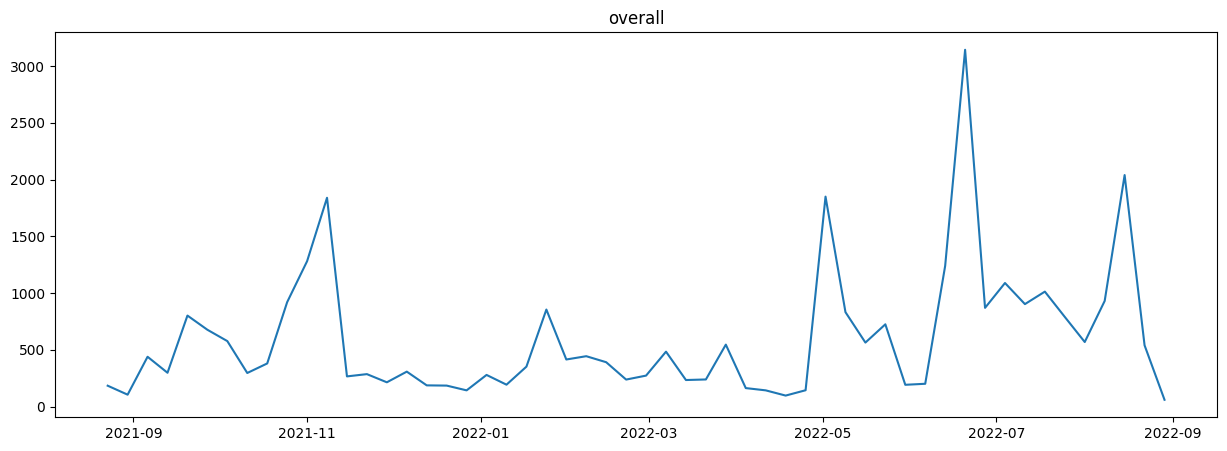

In [13]:
main_ts = df[['ts','id','y']]
#main_ts = main_ts.set_index("ts").groupby('id').resample('MS',label='left',closed = 'left').sum().drop(columns={'id'}).reset_index()
ts = main_ts.groupby("ts").sum()
plt.figure(figsize=(15,5))
plt.plot(ts.y)
plt.title('overall')
plt.show()

### Attributes

In [14]:
df.head()

ts  id     y  cases                               description  \
0 2021-08-23   1   1.0     57      FAB CLEANSER EUP 142G(50Z)X57 NONSTK   
1 2021-08-23   3   8.0     69       FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23   
2 2021-08-23   4  21.0     42    FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK   
3 2021-08-23   5   8.0     48  FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK   
4 2021-08-23   6   6.0     48  FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK   

         level2  prod_code prod_hierarchy  size       sku  \
0          None   10024916            FAB   5.0  80702886   
1  Ultra Repair   10024914            FAB   1.7  82332207   
2  Ultra Repair    9222618            FAB   2.0  82332208   
3  Ultra Repair   10024913            FAB   6.0  82332219   
4  Ultra Repair   10080881            FAB   6.0  82332800   

                                            sku_desc  sku_type units  __idx  \
0  FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...  Cleanser    Oz      1   
1  FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [823...     Serum    Oz      3   
2  FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332...     Cream    Oz      4   
3  FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [...     Toner    Oz      5   
4  FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800...     Toner    Oz      6   

   month  woy  
0      8   34  
1      8   34  
2      8   34  
3      8   34  
4      8   34

In [15]:
att_cols = ["id", "sku_desc", "sku", "prod_hierarchy", "prod_code", "description", "sku_type", "size", "units", "cases", "level2"]
att = df[att_cols].drop_duplicates()
att.reset_index(inplace=True, drop=True)
print("Att", att.shape)

Att (7, 11)


In [16]:
from feature_engineering_fab_weekly import get_features, get_events, get_events_full_data, calc_metrics, mean_encode

In [17]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')
events['main_promo'] = events['main_promo'].astype('int64')
events['small_promo'] = events['small_promo'].astype('int64')
events_weekly = []

for h in events.holiday.unique():
    # for each event, resample it to W-Mon
    e = events.loc[events.holiday == h]
    e = e.set_index("ds").resample(freq, label="left").first()
    e.dropna(inplace=True)
    events_weekly.append(e.reset_index())
event_types = pd.get_dummies(events["type"]).columns.to_list()
event_types1 = pd.get_dummies(events["impact"]).columns.to_list()
events_weekly = pd.concat(events_weekly)
tmp = []
for t in events_weekly.ds.unique():
    e = events_weekly.loc[events_weekly.ds == t].reset_index(drop=True)
    if len(e) == 1:
        tmp.append(e.drop(columns=["lower_window", "upper_window"]))
    else:
        e.drop(columns=["lower_window", "upper_window"], inplace=True)
        e["holiday"] = ",".join(e["holiday"].tolist())
        e["type"] = ",".join(e["type"].tolist())
        _sum = e[event_types].sum()
        for c in event_types:
            e[c] = _sum[c]
        tmp.append(e.drop_duplicates())
events_weekly = pd.concat(tmp)
events_weekly.sort_values(by="ds", inplace=True)
events_weekly.reset_index(inplace=True, drop=True)
del tmp, e
events_monthly =  events_weekly
events_monthly.sort_values(by="ds", inplace=True)
events_monthly.reset_index(drop=True, inplace=True)
events_monthly.head()
events_monthly.sort_values(by=['ds','type'], inplace = True)
events.sort_values(by=['ds','type'], inplace = True)

## Dates

## HW-ETS

In [18]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [19]:
from pg_features_weekly import resample_data, make_future_df, extract_summary

In [20]:
value_var = 'y'
time_var="ts"
group_var="id"
non_static_cols=None
fill_with_nan = False
groups = None
summary_stats = None
use_val=False
nan_ratio=0.5
n_jobs=0
features_dfs = {}
for version in all_dates.keys():
    print("Resampling")
    df_resample = resample_data(
        df,
        value_var=value_var,
        time_var=time_var,
        group_var=group_var,
        freq=freq
    )
    print(df_resample.shape)

    # 2. make future
    print("Make future")
    df_future = make_future_df(
        df_resample,
        all_dates[version]["forecast"],
        date_col=time_var,
        non_static_cols=non_static_cols,
        fill_with_nan=fill_with_nan,
        freq=freq,
    )
     # 3. create days features
    print("Create days features")
    df_future["year"] = df_future["ts"].dt.year
    df_future["month"] = df_future["ts"].dt.month
    df_future["week"] = df_future["ts"].dt.week
    df_future["quarter"] = df_future["ts"].dt.quarter
    if freq == "W-Mon":
        df_future["woy"] = df_future["ts"].dt.isocalendar().week
        df_future["woy"] = df_future["woy"].astype(int)
    df_future["is_month_start"] = df_future["ts"].dt.is_month_start
    df_future["is_month_end"] = df_future["ts"].dt.is_month_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_quarter_end"] = df_future["ts"].dt.is_quarter_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_year_start"] = df_future["ts"].dt.is_year_start
    df_future["is_year_end"] = df_future["ts"].dt.is_year_end
    if groups is None:
        groups = [
            ['sku'],
            ["sku", "month"],
            ["sku", "week"]
        ]
        if freq == "MS":
            groups = groups[:-1]

    print("Create summary features")
    print(groups)
    df_summary = df_future.copy()
    for g in groups:
        df_summary = extract_summary(
            df_summary,
            all_dates[version],
            group=g,
            var_name=value_var,
            summary_stats=summary_stats,
            use_val=use_val,
        )
    
    df_feature = df_summary.copy()
    df_with_event =  get_events_full_data(df_feature, events_monthly, events, event_types, event_types1)
    
    
    _df = df_feature.copy()
    outlier_quantile=0.9
    _df = _df.loc[_df.ts < all_dates[m]["test"].min()].reset_index()
    aa = []
    for _id in _df.id.unique():

        ts = _df.loc[_df.id == _id]
        outliers = np.quantile(ts.y, outlier_quantile)
        ts = ts.loc[ts.y <= outliers]
        aa.append(ts)
    aa = pd.concat(aa)
    #aa = aa[aa['y'] > 0]
    avgs = aa.groupby(["id"])["y"].mean().reset_index()
    avgs.rename(columns={"y": "average_train_demand"}, inplace=True)
    df_with_train = pd.merge(df_with_event.copy(), avgs, on=["id"], how="left")
    print(version)
    a = df_with_train
    a = a[ (a['sku'] == 815517026005) & (a['ts'] == '2022-07-01')]
    a = a[['ts','y']]
    print(a)
    
    cols = ["y", "days_to_next_event", "days_since_last_event", "weeks_to_next_event", "weeks_since_last_event"]

    _df = df_with_train.copy()
    _df["lag_demand"] = _df.groupby(["id"])["y"].shift(52)
    _df.loc[_df['lag_demand'].isnull(),'lag_demand'] = _df.loc[_df['lag_demand'].isnull(),'y_mean_sku_month']
    _df.loc[_df['y_mean_sku_month'].isnull(),'y_mean_sku_month'] = _df.loc[_df['y_mean_sku_month'].isnull(),'average_train_demand']
    _df.loc[_df['lag_demand'].isnull(),'lag_demand'] = _df.loc[_df['lag_demand'].isnull(),'average_train_demand']
    df_with_train = _df.copy()
    features_dfs.update({version: df_with_train})


Resampling
(370, 16)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month'], ['sku', 'week']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['sku', 'week', 'y_sum_sku_week', 'y_mean_sku_week', 'y_max_sku_week', 'y_min_sku_week', 'y_std_sku_week']
['festival', 'promotion_specific_date']


/tmp/ipykernel_4140761/4022246762.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_future["week"] = df_future["ts"].dt.week


2022-08-01
Empty DataFrame
Columns: [ts, y]
Index: []
Resampling
(370, 16)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month'], ['sku', 'week']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['sku', 'week', 'y_sum_sku_week', 'y_mean_sku_week', 'y_max_sku_week', 'y_min_sku_week', 'y_std_sku_week']
['festival', 'promotion_specific_date']


/tmp/ipykernel_4140761/4022246762.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_future["week"] = df_future["ts"].dt.week


2022-07-04
Empty DataFrame
Columns: [ts, y]
Index: []
Resampling
(370, 16)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month'], ['sku', 'week']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['sku', 'week', 'y_sum_sku_week', 'y_mean_sku_week', 'y_max_sku_week', 'y_min_sku_week', 'y_std_sku_week']
['festival', 'promotion_specific_date']


/tmp/ipykernel_4140761/4022246762.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_future["week"] = df_future["ts"].dt.week


2022-06-06
Empty DataFrame
Columns: [ts, y]
Index: []


In [21]:
features_dfs[m].to_csv("sasdsa.csv")

In [22]:
def ets_forecast(
    series,
    train_dates,
    test_dates,
):    
    if len(series) > 0:
        # time series must not be empty!

        # fit parameters on val
        train = series.loc[series.index.isin(train_dates)]
        test = series.loc[series.index.isin(test_dates)]

        if np.sum(train) == 0:
            # special case when all the values are 0
            out = np.zeros(len(train)+len(test))
            
            return out

        # do cross validation
        configs = [True, False]
        error = ["add"]
        trend = ["add"]
        damped_trend = [True, False]
        seasonal = [None, "add"]
        seasonal_periods = [4,6,12]
        best_config = None
        best_metric = np.inf
        best_quantile = None
        best_model = None
        for q in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for e in error:
                for t in trend:
                    for d in damped_trend:
                        for s in seasonal:
                            if s is None:
                                model = ETSModel(
                                    np.clip(train, 0, np.quantile(train[np.where(train > 0)[0][0]:], q)),
                                    error=e,
                                    trend=t,
                                    seasonal=s,
                                    damped_trend=d,
                                    seasonal_periods=None,
                                ).fit(disp = 0)
                                
                                yhat = model.predict(0, len(train) - 1)
                                yhat = np.array(yhat)
                                yhat = np.clip(yhat, 0, None)
                                
                                rmse = (train.values - yhat) * (train.values - yhat)
                                rmse = np.sqrt(np.mean(rmse))

                                if rmse < best_metric:
                                    best_metric = rmse
                                    best_model = model
                            else:
                                for ss in seasonal_periods:
                                    model = ETSModel(
                                        np.clip(train, 0, np.quantile(train[np.where(train > 0)[0][0]:], q)),
                                        error=e,
                                        trend=t,
                                        seasonal=s,
                                        damped_trend=d,
                                        seasonal_periods=ss,
                                    ).fit(disp = 0)

                                    yhat = model.predict(0, len(train) - 1)
                                    yhat = np.array(yhat)
                                    yhat = np.clip(yhat, 0, None)

                                    rmse = (train.values - yhat) * (train.values - yhat)
                                    rmse = np.sqrt(np.mean(rmse))

                                    if rmse < best_metric:
                                        best_metric = rmse
                                        best_model = model

        # do forecast on train
        yhat_train = best_model.predict(0, len(train) - 1)
        yhat_train = np.array(yhat_train)
        yhat_train = np.clip(yhat_train, 0, None)
        
        # first forecast on test to get a sense of how well the model performs
        yhat_test = best_model.forecast(len(test))
        yhat_test = np.array(yhat_test)
        yhat_test = np.clip(yhat_test, 0, None)
        
        # concatenate all predictions
        out = np.concatenate((yhat_train, yhat_test))

        return out

    return None

In [23]:
def forecast_ets(
    data,
    dates,
    num_cores=-1,
    freq="MS",
):
    import multiprocessing
    from pandarallel import pandarallel
    
    import warnings
    import logging
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    
    np.seterr(divide='ignore', invalid='ignore')
    warnings.simplefilter('ignore', ConvergenceWarning)
    logging.getLogger('prophet').setLevel(logging.ERROR)
    
    if num_cores < 0:
        num_cores = multiprocessing.cpu_count()
    else:
        num_cores = min(num_cores, multiprocessing.cpu_count())
        
    pandarallel.initialize(
        nb_workers=num_cores,
        verbose=0,
        progress_bar=True
    )
    
    train_dates = dates["train"]
    test_dates = dates["test"]
    
    s = data.set_index(["id", "ts"], drop=True)["y"]
    s = s.unstack(0).fillna(0)
    s = s.asfreq(freq)
    
    print(train_dates)
    print(test_dates)
    yhat = s.parallel_apply(lambda x: ets_forecast(
        x,
        train_dates,
        test_dates,
    ), axis=0)
    
    

    yhat = yhat.reset_index(drop=True).apply(lambda x: pd.Series(x.dropna().values)).dropna()

    yhat["ts"] = pd.date_range(
        start=max(np.min(train_dates), data.ts.min()),
        end=np.max(test_dates),
        freq=freq
    )
    
    yhat = pd.melt(yhat, id_vars=['ts'], var_name="id", value_name="yhat")
    yhat = pd.merge(df, yhat, on=["ts", "id"], how="left")
    
    yhat = yhat[["id", "ts", "y", "yhat"]+[x for x in yhat.columns if x not in ["id", "ts", "y", "yhat"]]]
          
    return yhat.reset_index(drop=True)

In [24]:
pred_hws = {}
for i in range(len(versions)):
    pred_hw = forecast_ets(
        df,
        all_dates[versions[i]],
        num_cores=-1,
        freq=freq,
    )
    pred_hw.rename(columns={'yhat':'hw_yhat'}, inplace = True)
    pred_hws.update({versions[i]: pred_hw})

DatetimeIndex(['2021-08-23', '2021-08-30', '2021-09-06', '2021-09-13',
               '2021-09-20', '2021-09-27', '2021-10-04', '2021-10-11',
               '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
               '2021-11-15', '2021-11-22', '2021-11-29', '2021-12-06',
               '2021-12-13', '2021-12-20', '2021-12-27', '2022-01-03',
               '2022-01-10', '2022-01-17', '2022-01-24', '2022-01-31',
               '2022-02-07', '2022-02-14', '2022-02-21', '2022-02-28',
               '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28',
               '2022-04-04', '2022-04-11', '2022-04-18', '2022-04-25',
               '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23',
               '2022-05-30', '2022-06-06', '2022-06-13', '2022-06-20',
               '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18',
               '2022-07-25'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22'

DatetimeIndex(['2021-08-23', '2021-08-30', '2021-09-06', '2021-09-13',
               '2021-09-20', '2021-09-27', '2021-10-04', '2021-10-11',
               '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
               '2021-11-15', '2021-11-22', '2021-11-29', '2021-12-06',
               '2021-12-13', '2021-12-20', '2021-12-27', '2022-01-03',
               '2022-01-10', '2022-01-17', '2022-01-24', '2022-01-31',
               '2022-02-07', '2022-02-14', '2022-02-21', '2022-02-28',
               '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28',
               '2022-04-04', '2022-04-11', '2022-04-18', '2022-04-25',
               '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23',
               '2022-05-30', '2022-06-06', '2022-06-13', '2022-06-20',
               '2022-06-27'],
              dtype='datetime64[ns]', freq='W-MON')
DatetimeIndex(['2022-07-04', '2022-07-11', '2022-07-18', '2022-07-25'], dtype='datetime64[ns]', freq='W-MON')


DatetimeIndex(['2021-08-23', '2021-08-30', '2021-09-06', '2021-09-13',
               '2021-09-20', '2021-09-27', '2021-10-04', '2021-10-11',
               '2021-10-18', '2021-10-25', '2021-11-01', '2021-11-08',
               '2021-11-15', '2021-11-22', '2021-11-29', '2021-12-06',
               '2021-12-13', '2021-12-20', '2021-12-27', '2022-01-03',
               '2022-01-10', '2022-01-17', '2022-01-24', '2022-01-31',
               '2022-02-07', '2022-02-14', '2022-02-21', '2022-02-28',
               '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28',
               '2022-04-04', '2022-04-11', '2022-04-18', '2022-04-25',
               '2022-05-02', '2022-05-09', '2022-05-16', '2022-05-23',
               '2022-05-30'],
              dtype='datetime64[ns]', freq='W-MON')
DatetimeIndex(['2022-06-06', '2022-06-13', '2022-06-20', '2022-06-27'], dtype='datetime64[ns]', freq='W-MON')


In [25]:
yhat_hws = {}
for i in range(len(versions)):
    yhat_hw = pred_hws[versions[i]]
    yhat_hws.update({versions[i]: yhat_hw})

In [26]:
df.ts.min()

Timestamp('2021-08-23 00:00:00')

### Results

## Features

### Cluster - Scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

In [28]:
x_clust_all = {}

this_df = df[df['ts'] < np.min(all_dates[m]['forecast'])]
x_clust = this_df.pivot_table(index="id", columns="ts", values="y").fillna(0)
a = MinMaxScaler().fit_transform(x_clust.transpose()).transpose()
x_clust.loc[:, :] = a
x_clust.head()

ts  2021-08-23  2021-08-30  2021-09-06  2021-09-13  2021-09-20  2021-09-27  \
id                                                                           
0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1     0.000000    0.080000    0.240000    0.220000    0.660000    0.540000   
3     0.177778    0.044444    0.177778    0.000000    0.444444    0.266667   
4     0.110526    0.042105    0.136842    0.031579    0.131579    0.089474   
5     0.029240    0.017544    0.099415    0.070175    0.508772    0.479532   

ts  2021-10-04  2021-10-11  2021-10-18  2021-10-25  2021-11-01  2021-11-08  \
id                                                                           
0     0.000000    0.000000    0.090253    0.468412    0.710289    1.000000   
1     0.400000    0.200000    0.080000    0.200000    0.560000    0.980000   
3     0.266667    0.155556    0.066667    0.155556    0.333333    0.377778   
4     0.078947    0.031579    0.031579    0.078947    0.142105    0.157895   
5     0.233918    0.181287    0.128655    0.163743    0.315789    0.526316   

ts  2021-11-15  2021-11-22  2021-11-29  2021-12-06  2021-12-13  2021-12-20  \
id                                                                           
0     0.083935    0.116426    0.092960    0.121841    0.067690    0.049639   
1     0.160000    0.120000    0.040000    0.120000    0.020000    0.080000   
3     0.066667    0.133333    0.066667    0.088889    0.133333    0.222222   
4     0.063158    0.021053    0.031579    0.073684    0.036842    0.063158   
5     0.105263    0.070175    0.046784    0.052632    0.023392    0.070175   

ts  2021-12-27  2022-01-03  2022-01-10  2022-01-17  2022-01-24  2022-01-31  \
id                                                                           
0     0.040614    0.119134    0.035199    0.085740    0.329422    0.083032   
1     0.140000    0.160000    0.140000    0.240000    1.000000    0.440000   
3     0.022222    0.155556    0.155556    0.911111    1.000000    0.688889   
4     0.052632    0.057895    0.036842    0.110526    0.205263    0.147368   
5     0.035088    0.128655    0.093567    0.116959    0.438596    0.245614   

ts  2022-02-07  2022-02-14  2022-02-21  2022-02-28  2022-03-07  2022-03-14  \
id                                                                           
0     0.206679    0.185921    0.042419    0.115523    0.220217    0.045126   
1     0.120000    0.100000    0.160000    0.360000    0.460000    0.280000   
3     0.488889    0.288889    0.355556    0.311111    0.488889    0.311111   
4     0.089474    0.126316    0.000000    0.000000    0.026316    0.042105   
5     0.000000    0.134503    0.111111    0.157895    0.175439    0.111111   

ts  2022-03-21  2022-03-28  2022-04-04  2022-04-11  2022-04-18  2022-04-25  \
id                                                                           
0     0.061372    0.347473    0.036101    0.045126    0.012635    0.054152   
1     0.260000    0.140000    0.120000    0.180000    0.040000    0.200000   
3     0.288889    0.155556    0.311111    0.133333    0.288889    0.088889   
4     0.036842    0.026316    0.036842    0.015789    0.031579    0.047368   
5     0.076023    0.122807    0.040936    0.046784    0.029240    0.040936   

ts  2022-05-02  2022-05-09  2022-05-16  2022-05-23  2022-05-30  2022-06-06  \
id                                                                           
0     0.750000    0.065884    0.048736    0.020758    0.017148    0.004513   
1     0.480000    0.260000    0.280000    0.160000    0.060000    0.100000   
3     0.622222    0.311111    0.222222    0.222222    0.133333    0.111111   
4     0.842105    1.000000    0.684211    0.268421    0.157895    0.078947   
5     0.228070    0.461988    0.146199    0.128655    0.035088    0.035088   

ts  2022-06-13  2022-06-20  2022-06-27  2022-07-04  2022-07-11  2022-07-18  \
id                                                                           
0     0.000000 

In [29]:
n_clusters = 3
this_df = df[df['ts'] < np.min(all_dates[m]['forecast'])]

clust_model = AgglomerativeClustering(
    n_clusters=n_clusters,
    linkage="ward",
    compute_distances=True
)
clust_model = clust_model.fit(x_clust)



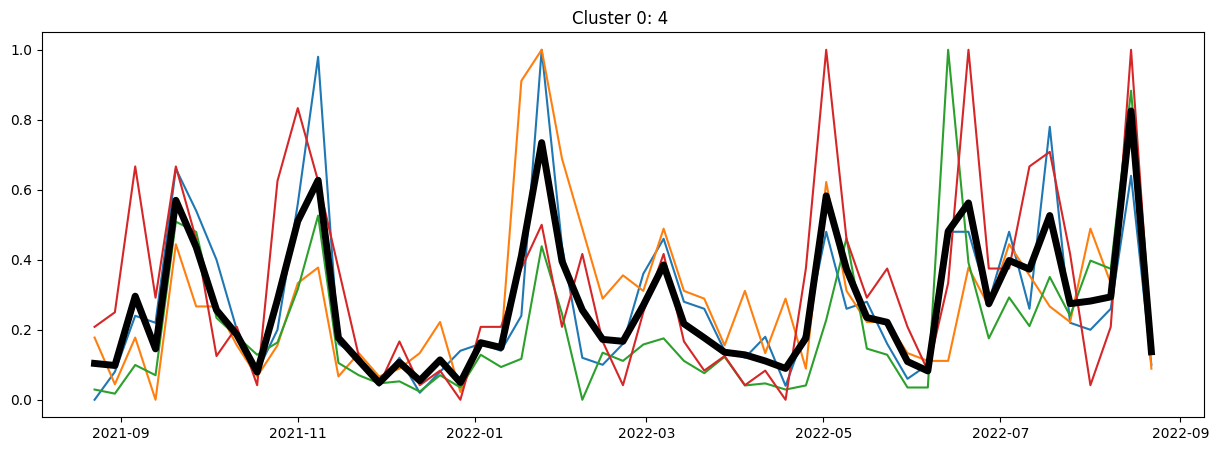

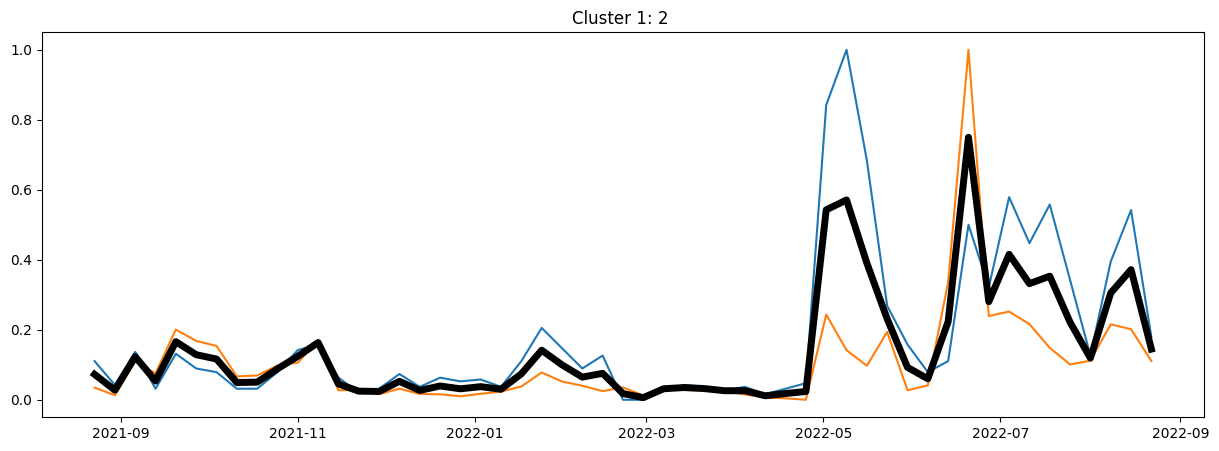

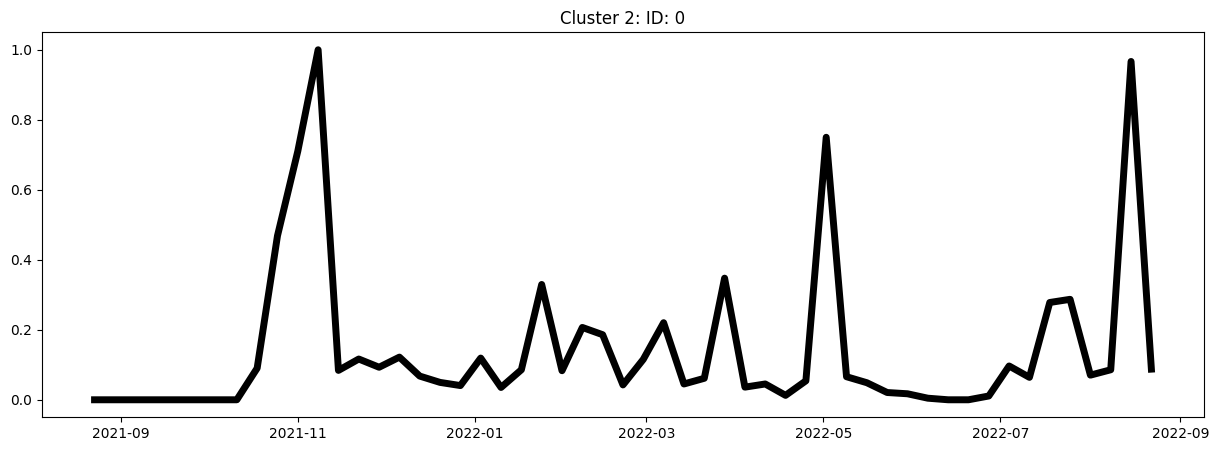

In [30]:
cluster_average = []
all_ids = x_clust.index
for i in range(n_clusters):
    idx = np.where(clust_model.labels_==i)
    idx2 = all_ids[idx[0]]

    ts = x_clust.loc[idx2].values
    t = x_clust.columns

    avg = ts.mean(axis=0)
    cluster_average.append(pd.DataFrame({"ts": t, "y": avg, "cluster": i}))

    plt.figure(figsize=(15,5))
    for j in range(ts.shape[0]):
        plt.plot(t, ts[j])
    plt.plot(t, avg, "k", linewidth=5)
    if ts.shape[0] == 1:
        plt.title("Cluster {}: ID: {}".format(i, idx[0][0]))
    else:
        plt.title("Cluster {}: {} ".format(i, ts.shape[0]))
    plt.show()
cluster_average = pd.concat(cluster_average).reset_index(drop=True)


In [31]:
cluster_data = x_clust.copy()
cluster_data['id'] = cluster_data.index
cluster_data['cluster'] = clust_model.labels_
cluster_data.reset_index(drop=True,inplace=True)
cluster_data = cluster_data[['id','cluster']]
cluster_data.head()


ts  id  cluster
0    0        2
1    1        0
2    3        0
3    4        1
4    5        0

## RandomForest

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [33]:
drop_cols1 = [  'item_type', 'material', 
             'prod_code', 'level2', 'cases', 'sku_desc', 'uom', 'year', 'quarter', 'lag_demand', 'month', 'prod_hierarchy', 'description',
             'is_month_start', 'is_month_end', 'is_quarter_start', '__idx',  'is_quarter_end', 'is_year_start', 'y_sum_sku_month', 'y_max_sku_month', 'y_min_sku_month',
             'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku', 'sku_percent',
             'y_std_sku_month',  'y_max_sku_week', 'y_min_sku_week', 'y_sum_sku_week',
             'sku_month_percent', 'events', 'type', 'impact', 'festival', 'promotion_specific_date', 
             'last_event', 'next_event', 'y_max_month', 'y_min_month','y_mean_sku_month', 'y_mean_sku_week', 'y_std_sku_week',
       'sku_week_percent', 
             'days_since_last_event', 'days_to_next_event', 'dummy_spike', 
             'dummy_event_spike', 'dummy_spike_before_event']

In [34]:
features_dfs[m].drop(drop_cols1, axis=1, errors = 'ignore').columns

Index(['id', 'ts', 'y', 'size', 'sku', 'sku_type', 'units', 'woy', 'week',
       'main_promo', 'small_promo', 'weeks_since_last_event',
       'weeks_to_next_event', 'average_train_demand'],
      dtype='object')

In [35]:
features_dfs[m].columns

Index(['id', 'ts', 'y', 'cases', 'description', 'level2', 'prod_code',
       'prod_hierarchy', 'size', 'sku', 'sku_desc', 'sku_type', 'units',
       '__idx', 'month', 'woy', 'year', 'week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku',
       'y_std_sku', 'sku_percent', 'y_sum_sku_month', 'y_mean_sku_month',
       'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month',
       'sku_month_percent', 'y_sum_sku_week', 'y_mean_sku_week',
       'y_max_sku_week', 'y_min_sku_week', 'y_std_sku_week',
       'sku_week_percent', 'events', 'type', 'impact', 'festival',
       'promotion_specific_date', 'main_promo', 'small_promo', 'last_event',
       'next_event', 'weeks_since_last_event', 'weeks_to_next_event',
       'days_since_last_event', 'days_to_next_event', 'average_train_demand',
       'lag_demand'],
      dtype='object')

### Modeling

In [36]:
datas = {}
encoders = {}
for i in range(len(versions)):
    dates = all_dates[versions[i]]
    f = features_dfs[versions[i]].copy()
    f = pd.merge(f,cluster_data[['id','cluster']],on='id',how='left')
    #f = pd.merge(f, pred_hws[versions[i]][['ts','id','hw_yhat']], on=['id', 'ts'], how='left')
    f['week'] = f['ts'].dt.week
    #f.drop(lag_features, axis=1, inplace=True, errors = 'ignore')
    f.drop(drop_cols1, axis=1, inplace=True, errors = 'ignore')
    # get train, test, predict
    train = f.loc[f.ts < np.min(dates["test"])].reset_index(drop=True)
    test = f.loc[f.ts.isin(dates["test"])].reset_index(drop=True)
    predict = f.loc[f.ts.isin(dates["forecast"])].reset_index(drop=True)
    all_data = pd.concat([train, test]).reset_index(drop=True)

    train["y"] = train["y"].astype(float)
    test["y"] = test["y"].astype(float)
    predict["y"] = np.nan
    all_data["y"] = all_data["y"].astype(float)
    
    x_train, y_train = train.drop(columns=["y", "ts"]), train["y"]
    x_test, y_test = test.drop(columns=["y", "ts"]), test["y"]
    x_predict, y_predict = predict.drop(columns=["y", "ts"]), predict["y"]
    x_all, y_all = all_data.drop(columns=["y", "ts"]), all_data["y"]

    for c in x_train.select_dtypes(include=["number", "bool_"]).columns:
        x_train[c] = np.nan_to_num(x_train[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_test[c] = np.nan_to_num(x_test[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_predict[c] = np.nan_to_num(x_predict[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_all[c] = np.nan_to_num(x_all[c], nan=-9999, posinf=-9999, neginf=-9999)

    
    enc_cols = x_train.select_dtypes(exclude="number").columns.to_list()
    for col in enc_cols:
        enc = LabelEncoder()
        enc.fit(f[col])
        encoders.update({(versions[i], col): enc})
        x_train[col] = enc.transform(x_train[col])
        x_test[col] = enc.transform(x_test[col])
        x_predict[col] = enc.transform(x_predict[col])
        x_all[col] = enc.transform(x_all[col])
    print("forecast version {}".format(versions[i]))
    print(train.ts.min(), train.ts.max(), train.shape)
    print(test.ts.min(), test.ts.max(), test.shape)
    print(predict.ts.min(), predict.ts.max(), predict.shape)
    print()
    datas.update({
        versions[i] : {
            "all": all_data,
            "train": train,
            "test": test,
            "predict": predict,
            "x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test,
            "x_predict": x_predict,
            "y_predict": y_predict,
            "x_all": x_all,
            "y_all": y_all
        }
    })

forecast version 2022-08-01
2021-08-23 00:00:00 2022-07-25 00:00:00 (335, 15)
2022-08-01 00:00:00 2022-08-22 00:00:00 (28, 15)
2022-08-29 00:00:00 2023-08-28 00:00:00 (371, 15)

forecast version 2022-07-04
2021-08-23 00:00:00 2022-06-27 00:00:00 (307, 15)
2022-07-04 00:00:00 2022-07-25 00:00:00 (28, 15)
2022-08-01 00:00:00 2023-07-31 00:00:00 (371, 15)

forecast version 2022-06-06
2021-08-23 00:00:00 2022-05-30 00:00:00 (279, 15)
2022-06-06 00:00:00 2022-06-27 00:00:00 (28, 15)
2022-07-04 00:00:00 2023-07-03 00:00:00 (371, 15)



/tmp/ipykernel_4140761/3173267829.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  f['week'] = f['ts'].dt.week
/tmp/ipykernel_4140761/3173267829.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  f['week'] = f['ts'].dt.week
/tmp/ipykernel_4140761/3173267829.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  f['week'] = f['ts'].dt.week


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-08-01 2
2022-08-01 0


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-08-01 1


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


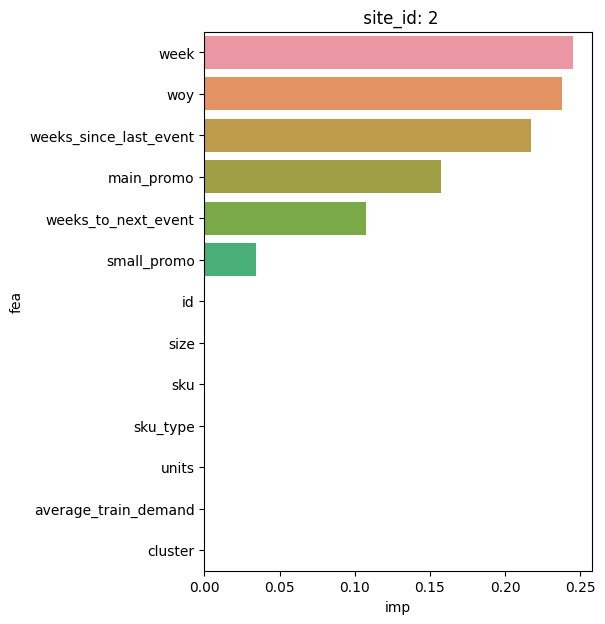

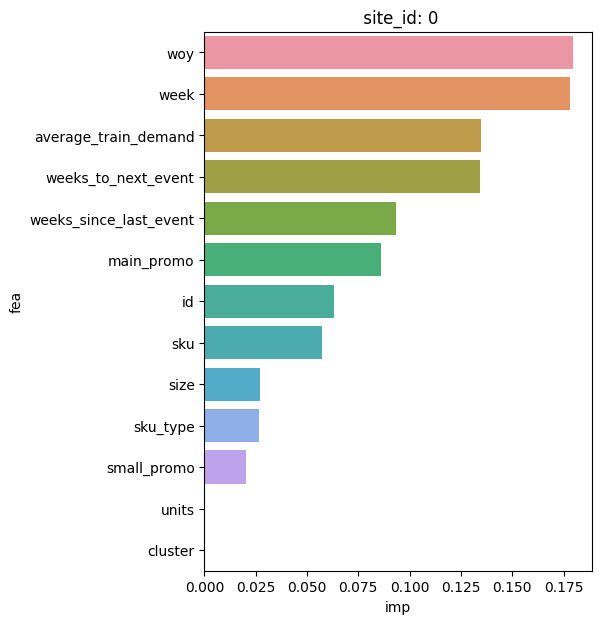

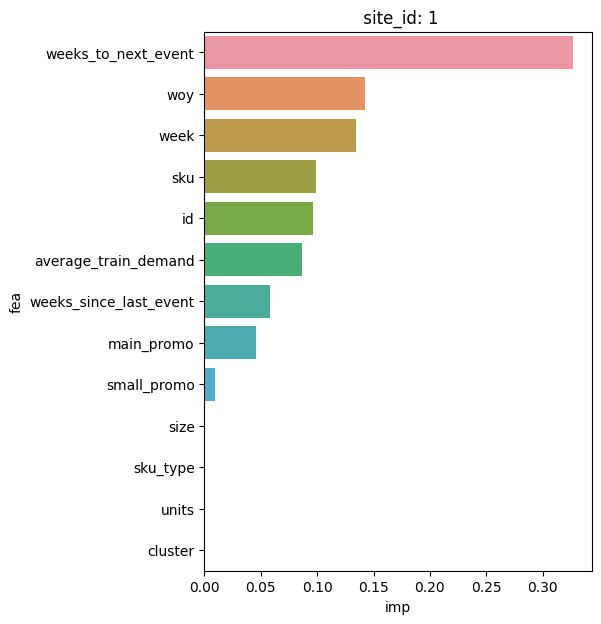

2022-07-04 2


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-07-04 0


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-07-04 1


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


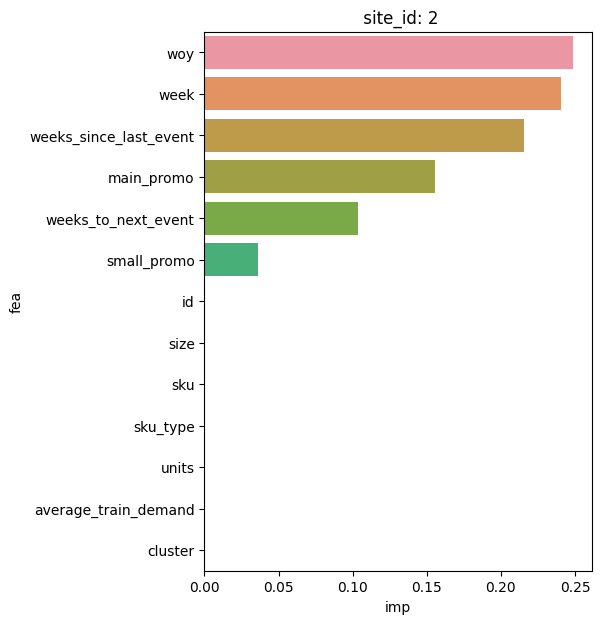

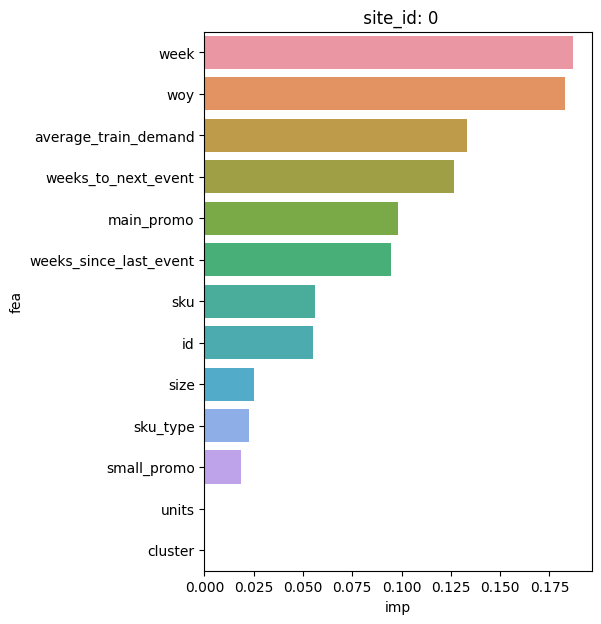

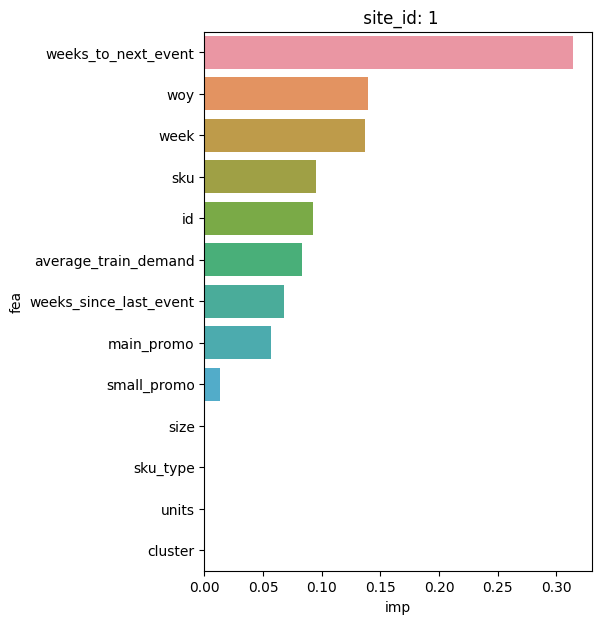

2022-06-06 2


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-06-06 0


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


2022-06-06 1


/home/jupyter-mallikarjuna.reddy-67928/.local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


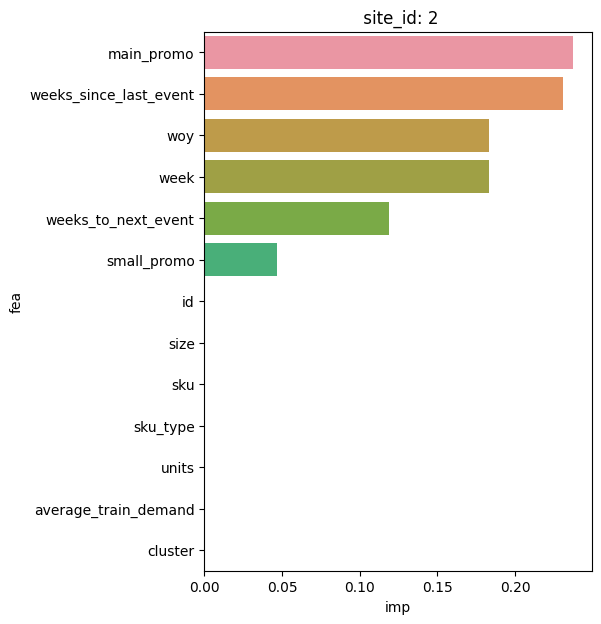

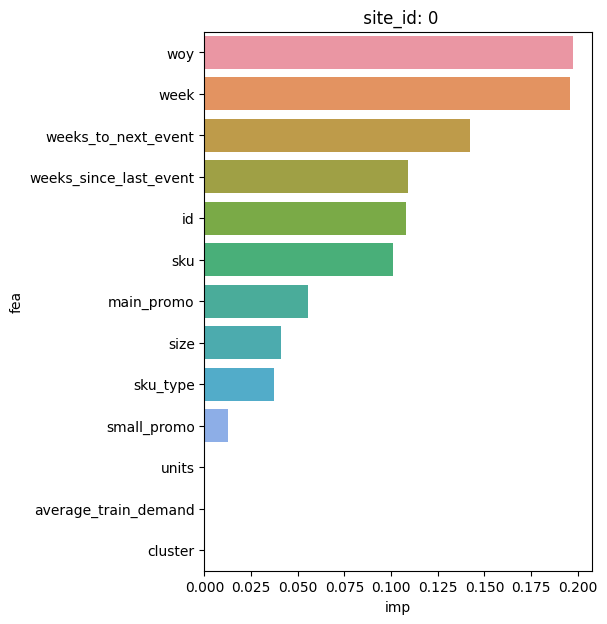

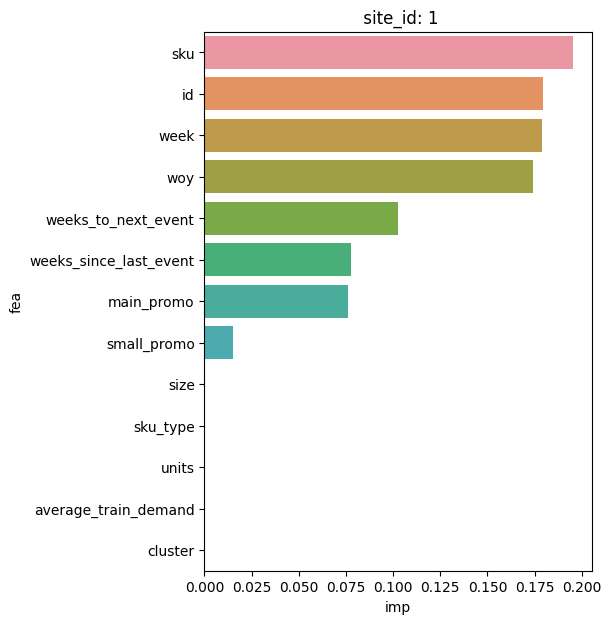

In [37]:
models = {}
clusters = {}
group_var = "cluster"
model_name = "Model per customer"
n_clusters = [1]
drop_cols = ["year", "basic_material", "material_description", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
# drop_cols = drop_cols + tsfresh_features

for i in range(len(versions)):
    _x_train = datas[versions[i]]["x_train"].copy()
    _y_train = datas[versions[i]]["y_train"].copy()
 
   
    if (group_var != "ALL"):
        groups = datas[versions[i]]["x_train"][group_var].unique()
    else:
        groups = ["ALL"]
        
    _model = {}
    if(groups[0] != "ALL"):
        for this_group in groups:
            print(versions[i], this_group)
            __x_train = _x_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)
            __y_train = _y_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)

            model = RandomForestRegressor(
                n_estimators=1000,
                criterion="mse",
                max_features="sqrt",
                random_state=0,
                max_samples=0.9,
                n_jobs=-1,  
                verbose=0,
            ) 
            __x_train.to_csv("op/fdsfsd.csv")
            if len(drop_cols) == 0:
                model.fit(__x_train, __y_train)
            else:
                model.fit(__x_train.drop(columns=drop_cols, errors="ignore"), __y_train)

            _model.update({this_group: model})
    else:
        _model = RandomForestRegressor(
            n_estimators=1000,
            criterion="mse",
            max_features="sqrt",
            random_state=0,
            max_samples=0.9,
            n_jobs=-1,  
            verbose=0,
        ) 
        if len(drop_cols) == 0:
            _model.fit(_x_train, _y_train)
        else:
            _model.fit(_x_train.drop(columns=drop_cols, errors="ignore"), _y_train)

        clust_model = None
        labels = None
        _model.update({"ALL": model})
    
    x_train = _x_train.drop(columns=drop_cols, errors="ignore") 
    for sn in _model.keys():
        fea_imp = pd.DataFrame({"fea": x_train.columns.to_list(), "imp": _model[sn].feature_importances_})
        fea_imp.sort_values(by="imp", inplace=True, ascending=False)
        fea_imp = fea_imp.head(20)
        plt.figure(figsize=(5, 7))
        sns.barplot(data=fea_imp, x="imp", y="fea")
        plt.title(" site_id: {}".format( sn))
        plt.show()
    models.update({versions[i]: _model})
    
    


In [38]:


predict_df = []
for i in range(len(versions)):
    
    x_train = datas[versions[i]]["x_train"]
    x_test = datas[versions[i]]["x_test"]
    x_predict = datas[versions[i]]["x_predict"]
    yhat_train = np.zeros(x_train.shape[0])
    yhat_test = np.zeros(x_test.shape[0])
    yhat_predict = np.zeros(x_predict.shape[0])
    
    _model = models[versions[i]]
    if (group_var != "ALL"):      
        for sn in _model.keys():
            model = _model[sn]
            yhat_train = model.predict(x_train.loc[x_train[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_test = model.predict(x_test.loc[x_test[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_predict = model.predict(x_predict.loc[x_predict[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            if (group_var in ["sku", "cluster"]) :  
                sn2 = sn
            else:
                sn2 = encoders[versions[i],group_var].inverse_transform([sn])[0]
            a = pd.concat([
                datas[versions[i]]["train"].loc[datas[versions[i]]["train"][group_var]==sn2], 
                datas[versions[i]]["test"].loc[datas[versions[i]]["test"][group_var]==sn2],
                datas[versions[i]]["predict"].loc[datas[versions[i]]["predict"][group_var]==sn2]
            ]).reset_index(drop=True)
            a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
            a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
            a["model"] = model_name
            a["version"] = versions[i]
            predict_df.append(a)
    else:
        model = _model['ALL']
        yhat_train = model.predict(x_train.drop(columns=drop_cols,errors= 'ignore'))
        yhat_test = model.predict(x_test.drop(columns=drop_cols,errors= 'ignore'))
        yhat_predict = model.predict(x_predict.drop(columns=drop_cols,errors= 'ignore'))

        sn2 = encoders[group_var].inverse_transform([sn])[0]
        a = pd.concat([
            datas[versions[i]]["train"], 
            datas[versions[i]]["test"],
            datas[versions[i]]["predict"]
        ]).reset_index(drop=True)
        a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
        a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
        a["model"] = model_name
        a["version"] = versions[i]
        predict_df.append(a)
predict_df = pd.concat(predict_df).reset_index(drop=True)  
predict_df = pd.merge(predict_df, att_main, on = 'sku', how = 'left')        

In [39]:
predict_df_op = []
predict_df_monthly_op = []
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
 
    ts = predict_df.loc[ (predict_df["version"] == versions[i])  ].reset_index(drop=True)
    
    ts.drop(columns={'y'}, inplace = True)
    ts = pd.merge(ts, df[['ts', 'id', 'y']], on = ['ts', 'id'], how = 'left')
    ts.loc[ts.ts < dates["test"][0], 'yhat'] = 0
    ts['y'] = ts['y'].fillna(0)
    
    ts_monthly = ts.set_index("ts").groupby(['version', 'id', 'sku']).resample('MS',label='left',closed = 'left').agg({'y':'sum',  'yhat':'sum'}).reset_index()
    predict_df_op.append(ts)
    predict_df_monthly_op.append(ts_monthly)
    
predict_df_op = pd.concat(predict_df_op).reset_index(drop=True)
predict_df_op.rename(columns={'yhat':'forecast','y':'actuals'},inplace = True)
predict_df_op = predict_df_op[['version',  'ts', 'id', 'sku', 'actuals', 'forecast']]
att_df1 = at[['cases', 'description', 'level2', 'prod_code', 'prod_hierarchy', 'size','sku', 'sku_desc', 'sku_type', 'units']].drop_duplicates()
print(predict_df_op.shape)
predict_df_op = pd.merge(predict_df_op,att_df1,on=['sku'])
print(predict_df_op.shape)
predict_df_op = pd.merge(predict_df_op,att_main,on='sku')
predict_df_op['date_num'] = pd.to_numeric(predict_df_op['ts'])

predict_df_monthly_op = pd.concat(predict_df_monthly_op).reset_index(drop=True)
predict_df_monthly_op.rename(columns={'yhat':'forecast','y':'actuals'},inplace = True)
predict_df_monthly_op = predict_df_monthly_op[['version',  'ts', 'id', 'sku', 'actuals', 'forecast']]

predict_df_monthly_op_long = predict_df_monthly_op.melt(id_vars=[ 'version',  'ts', 'id', 'sku'],var_name="type",value_name="value")
predict_df_monthly_op_long['value_category'] = predict_df_monthly_op_long['type'] + '_version_' + predict_df_monthly_op_long['version'].astype(str)
predict_df_monthly_op_long.loc[predict_df_monthly_op_long['type'] == 'actuals', 'value_category']  = 'Actuals'
predict_df_monthly_op_long.loc[predict_df_monthly_op_long['type'] == 'actuals', 'value_category']  = 'Actuals'
predict_df_monthly_op_long['keep_records'] = True
predict_df_monthly_op_long.loc[ (predict_df_monthly_op_long['value_category'] == 'Actuals') & (predict_df_monthly_op_long['version'] != m), 'keep_records'] = False
predict_df_monthly_op_long = predict_df_monthly_op_long[predict_df_monthly_op_long['keep_records'] == True]
predict_df_monthly_op_long.drop(columns = {'keep_records'}, inplace = True)

predict_df_monthly_op = pd.merge(predict_df_monthly_op,att_df1,on=['sku'])
predict_df_monthly_op = pd.merge(predict_df_monthly_op,att_main,on='sku')
predict_df_monthly_op['date_num'] = pd.to_numeric(predict_df_monthly_op['ts'])

predict_df_monthly_op_long = pd.merge(predict_df_monthly_op_long,att_df1,on=['sku'])
predict_df_monthly_op_long = pd.merge(predict_df_monthly_op_long,att_main,on='sku')
predict_df_monthly_op_long['date_num'] = pd.to_numeric(predict_df_monthly_op_long['ts'])

predict_df_monthly_op_long.head()

(2118, 6)
(2118, 15)


version         ts  id       sku     type   value value_category  cases  \
0  2022-08-01 2021-10-01   0  80692947  actuals   619.0        Actuals     78   
1  2022-08-01 2021-11-01   0  80692947  actuals  2220.0        Actuals     78   
2  2022-08-01 2021-12-01   0  80692947  actuals   310.0        Actuals     78   
3  2022-08-01 2022-01-01   0  80692947  actuals   723.0        Actuals     78   
4  2022-08-01 2022-02-01   0  80692947  actuals   610.0        Actuals     78   

                           description        level2  prod_code  \
0  FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW  Ultra Repair   10024911   
1  FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW  Ultra Repair   10024911   
2  FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW  Ultra Repair   10024911   
3  FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW  Ultra Repair   10024911   
4  FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW  Ultra Repair   10024911   

  prod_hierarchy  size                                           sku_desc  \
0            FAB   2.0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...   
1            FAB   2.0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...   
2            FAB   2.0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...   
3            FAB   2.0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...   
4            FAB   2.0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...   

  sku_type units shortname             date_num  
0    Cream    Oz     URC*3  1633046400000000000  
1    Cream    Oz     URC*3  1635724800000000000  
2    Cream    Oz     URC*3  1638316800000000000  
3    Cream    Oz     URC*3  1640995200000000000  
4    Cream    Oz     URC*3  1643673600000000000

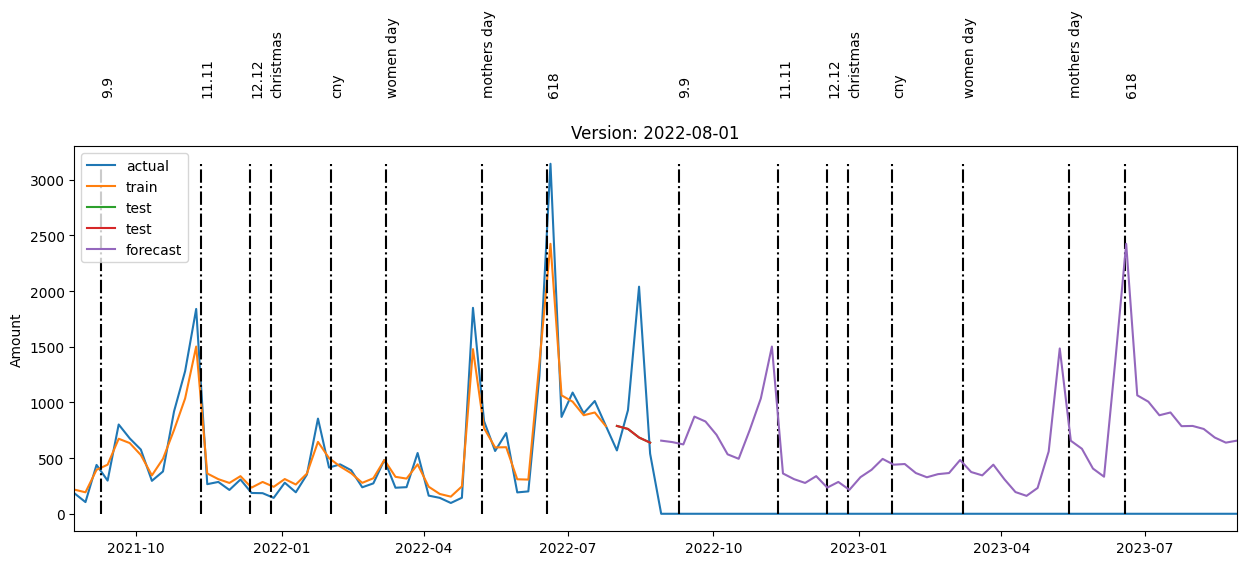

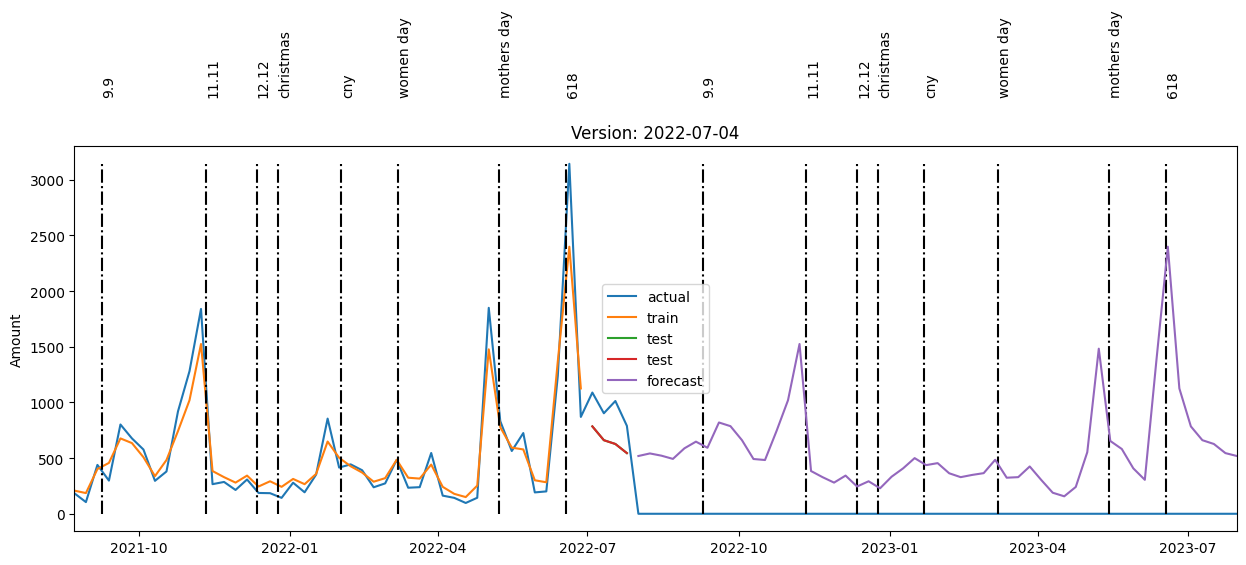

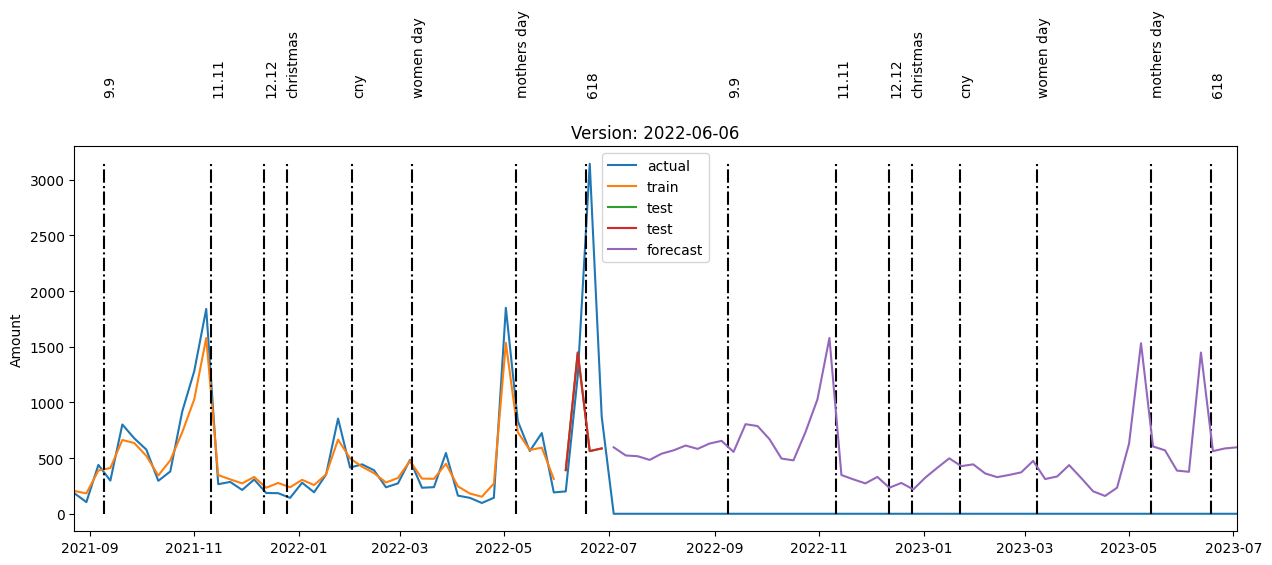

In [40]:
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
    ts = a.set_index("ts").resample(freq).sum().reset_index()
    
    
    train = ts.loc[ts.ts < dates["test"][0]]
    test = ts.loc[(ts.ts < dates["forecast"][0]) & (ts.ts >= dates["test"][0])]
    predict = ts.loc[ts.ts >= dates["forecast"][0]]
    all_ts = ts
    ts.loc[ts.ts < dates["test"][0], 'yhat']  = 0
    ts.loc[ts.ts < dates["test"][0], 'yhat']  = 0
    
    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")
    plt.plot(train.ts, train.yhat, label="train")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")
    for j in range(len(events)):
        plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
        if (events.ds[j] > a.ts.min()) and (events.ds[j] < a.ts.max()):
            plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
    plt.plot(test.ts, test.yhat, label="test")
    plt.plot(predict.ts, predict.yhat, label="forecast")
    plt.xlim([ts.ts.min(), ts.ts.max()])
    plt.ylabel("Amount")
    plt.title("Version: {}".format(versions[i]))
    plt.legend()
    plt.show()

/tmp/ipykernel_4140761/3375593981.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_4140761/3375593981.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_4140761/3375593981.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_4140761/3375593981.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(metrics, ignore_index=True, sort=False)
/tmp/ipykernel_4140761/3375593981.py

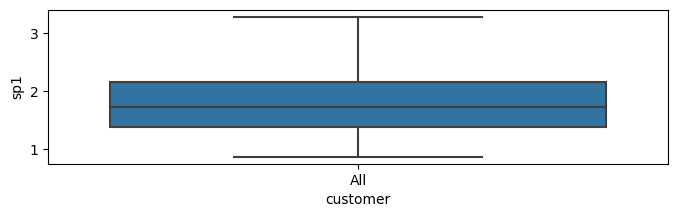

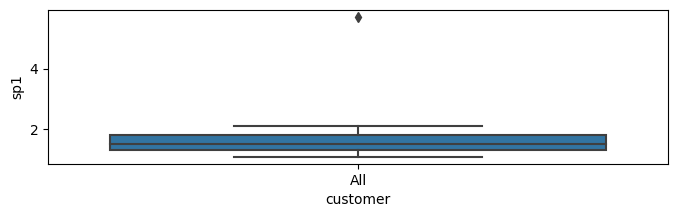

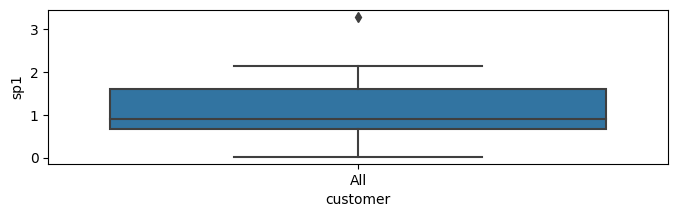

In [41]:
results = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "sku": ts["sku"][0],
            "test_start": all_dates[versions[i]]["test"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]

results.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results.groupby("sku").mean()
results.groupby("sku").median()
results['customer'] = 'All'
for i in range(len(versions)): 
    this_results = results[results['version'] == versions[i]]
    plt.figure(figsize=(8,2))
    #plt.ylim(0,15)
    sns.boxplot(data=this_results, y="sp1", x="customer")
    plt.show()

    

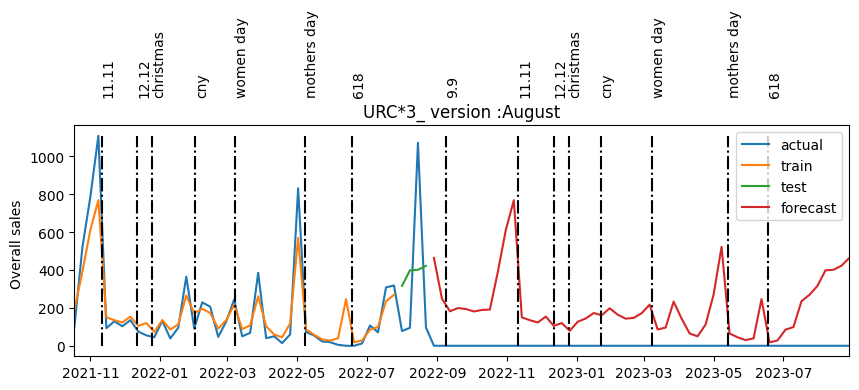

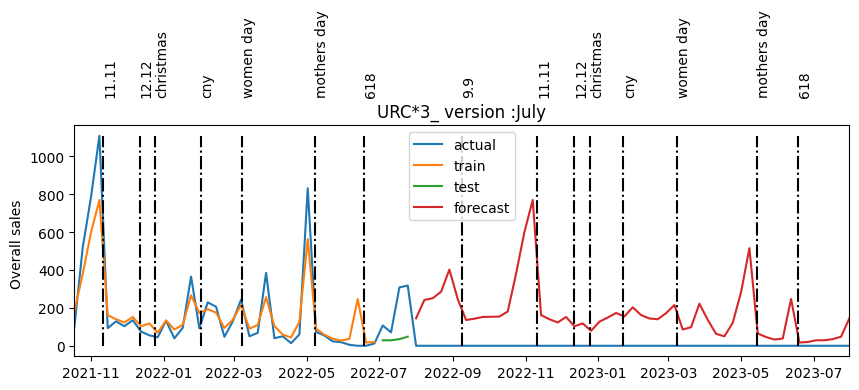

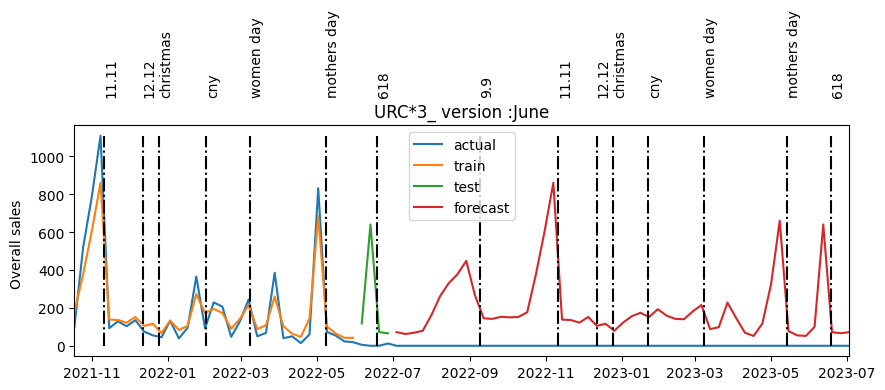

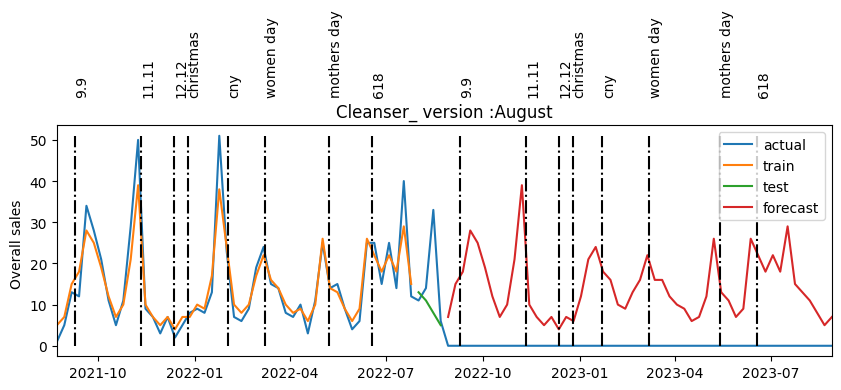

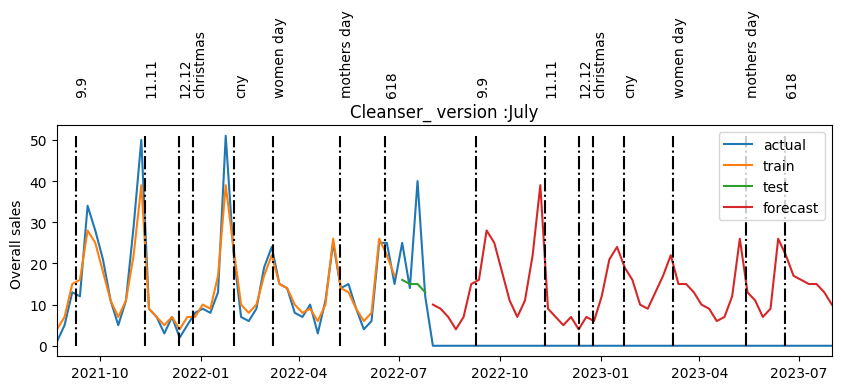

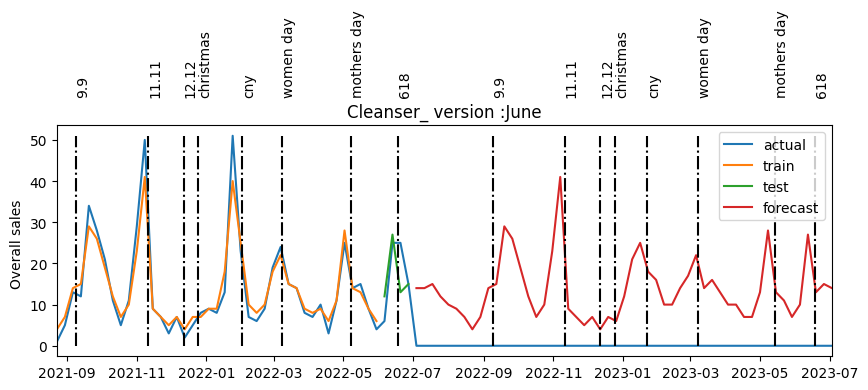

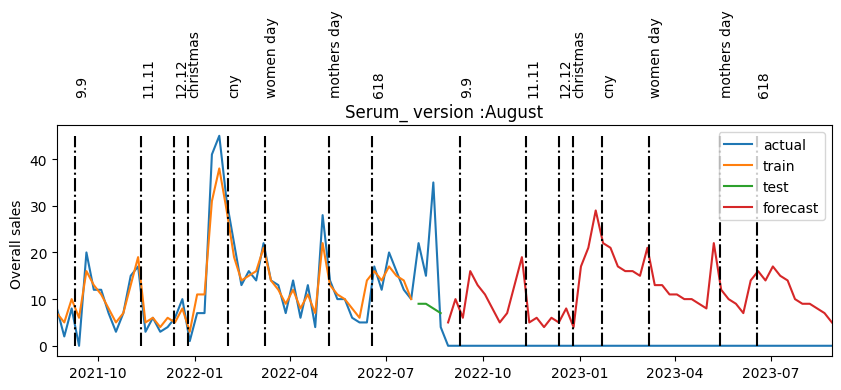

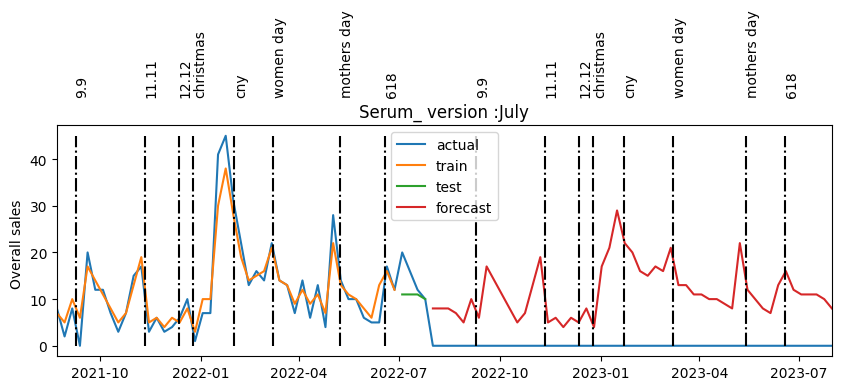

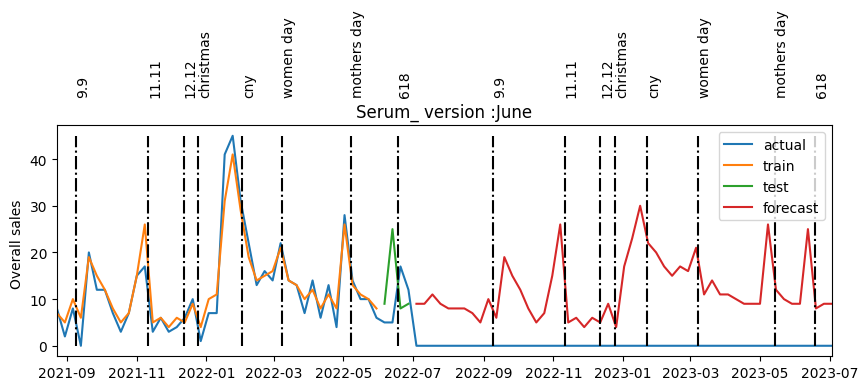

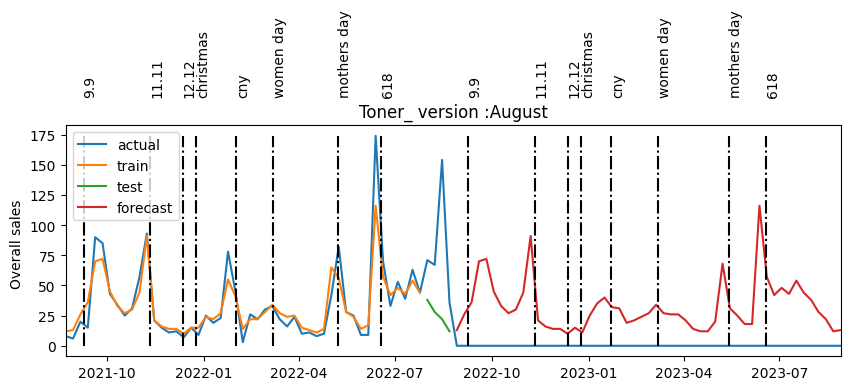

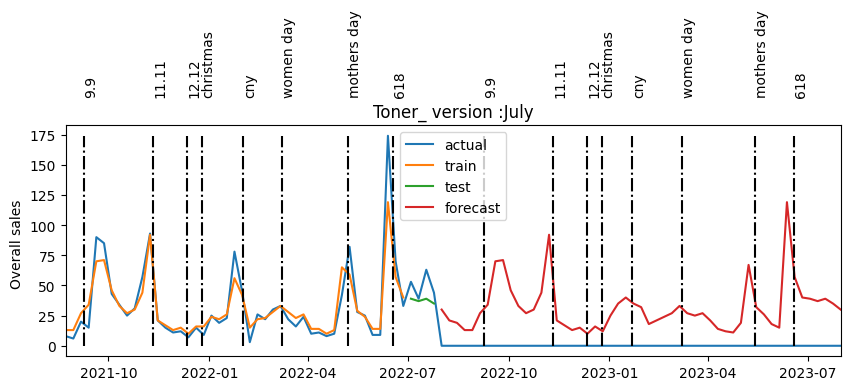

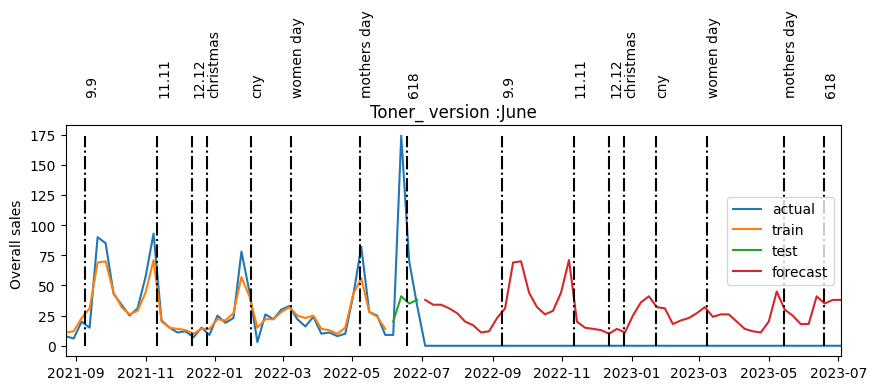

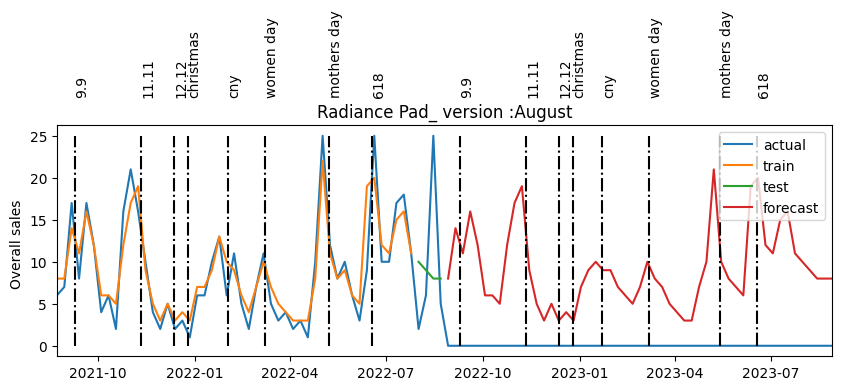

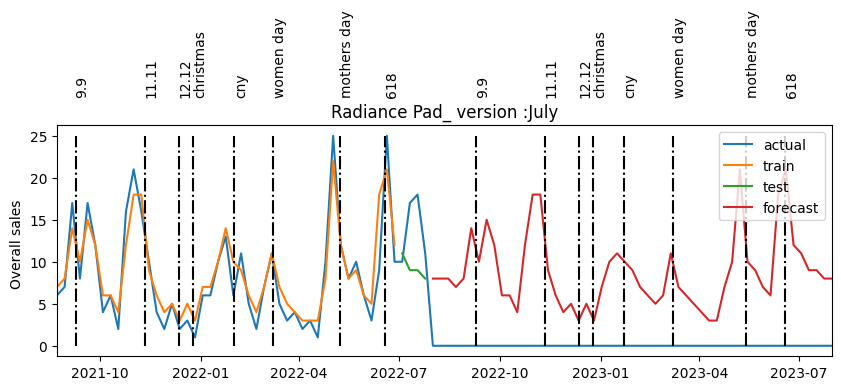

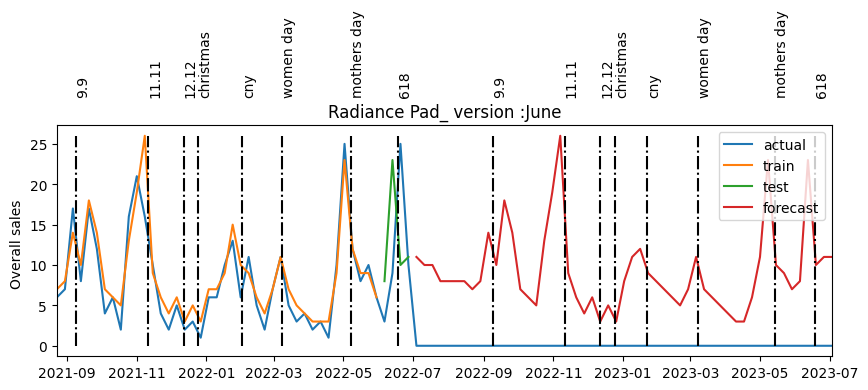

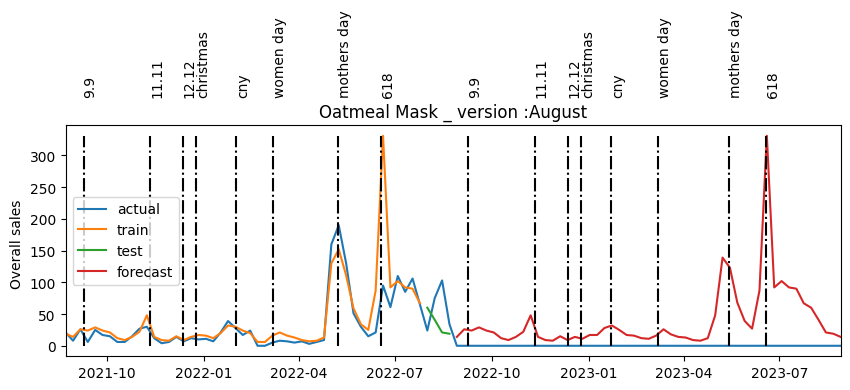

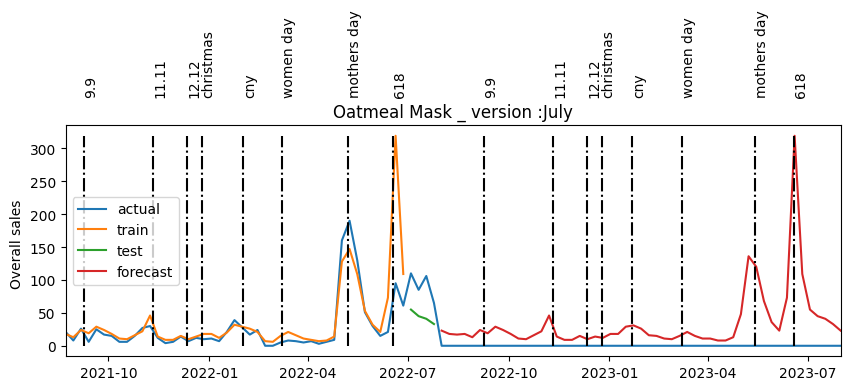

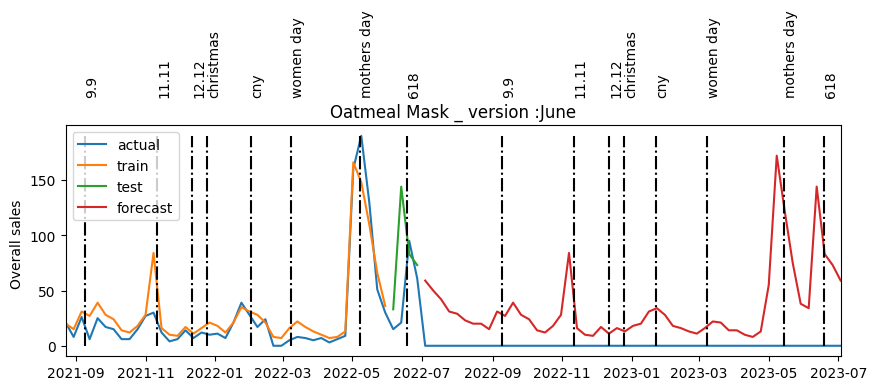

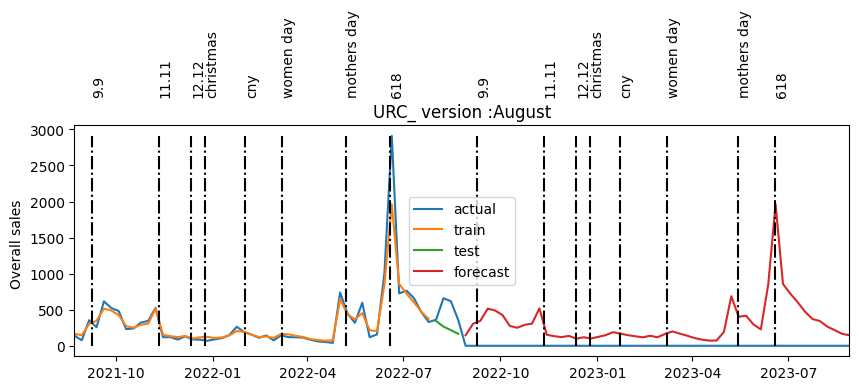

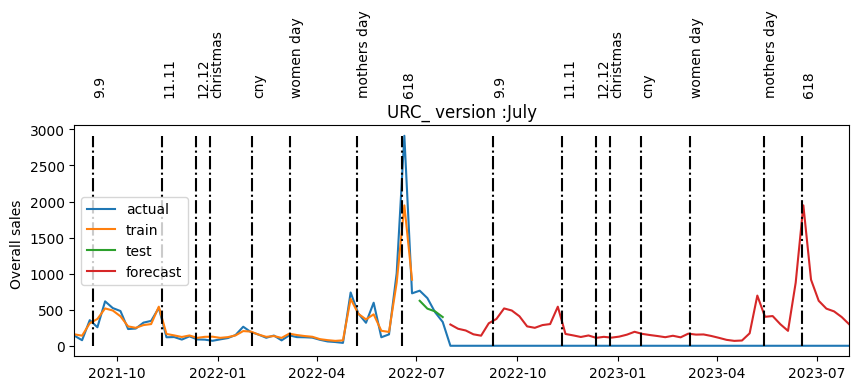

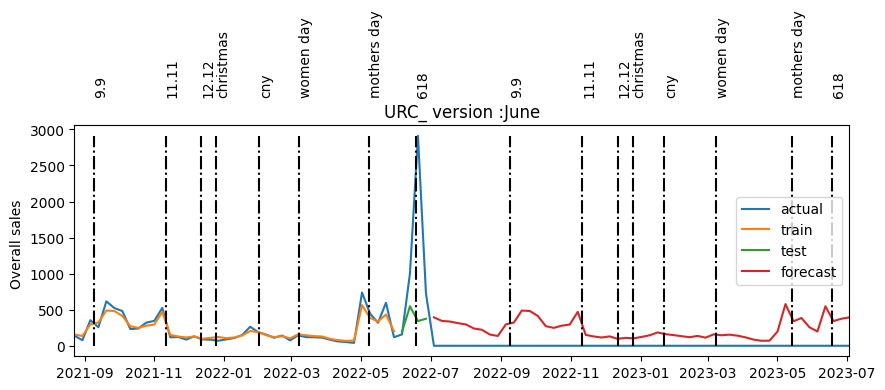

In [42]:
sku_custs =  predict_df.sku.unique()
for this_sku_cust in sku_custs :
    this_predict = predict_df[predict_df['sku'] == this_sku_cust]
    for i in range(len(versions)):
        this_ts = this_predict.loc[this_predict.version == versions[i]]
        sku_desc = this_ts.shortname.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(10,3))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title( str(sku_desc) + "_ version :" + str(pd.to_datetime(versions[i]).strftime("%B")))
        plt.legend()
        plt.show()

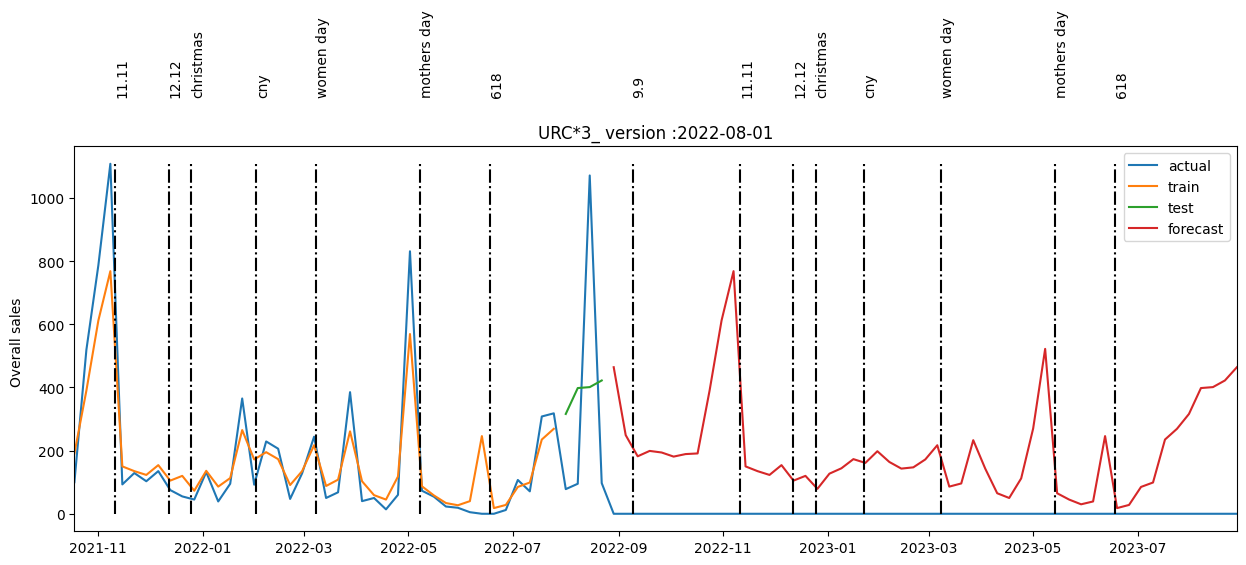

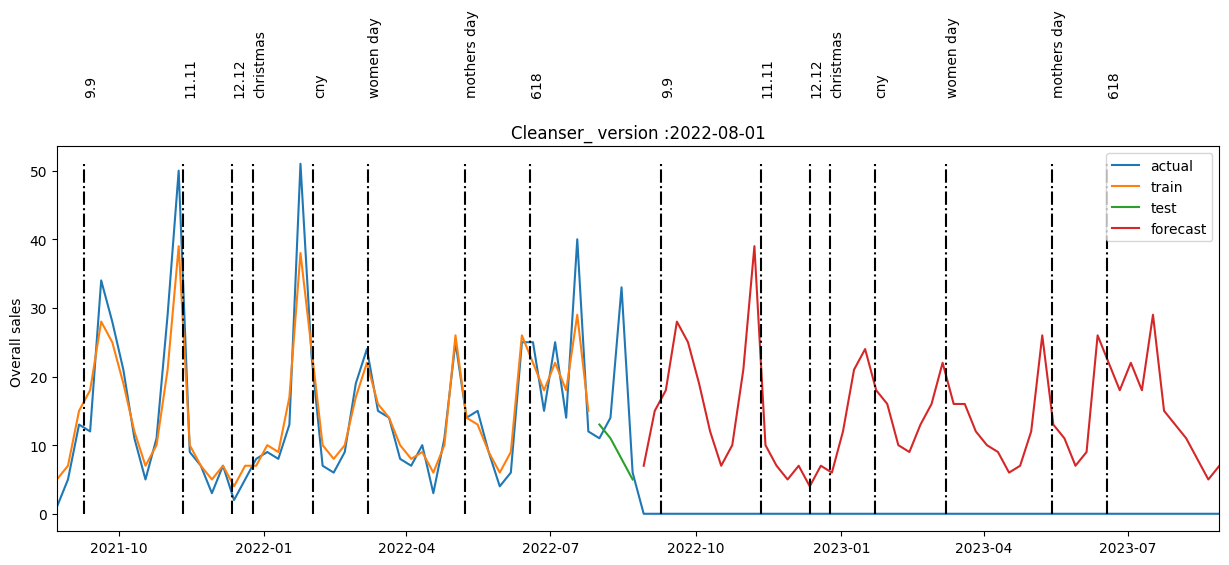

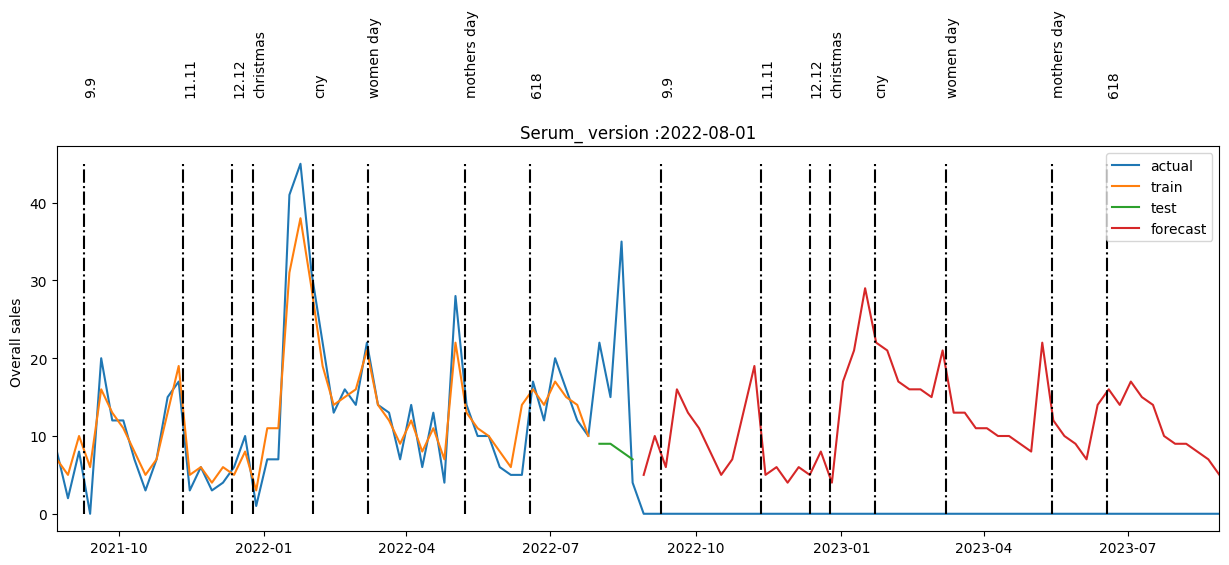

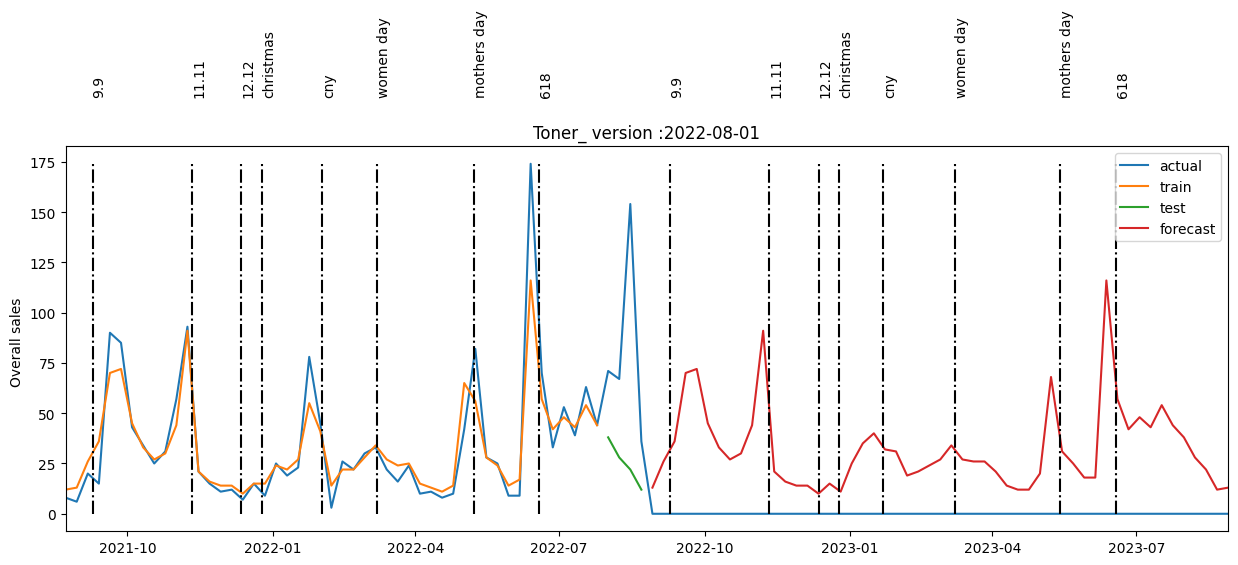

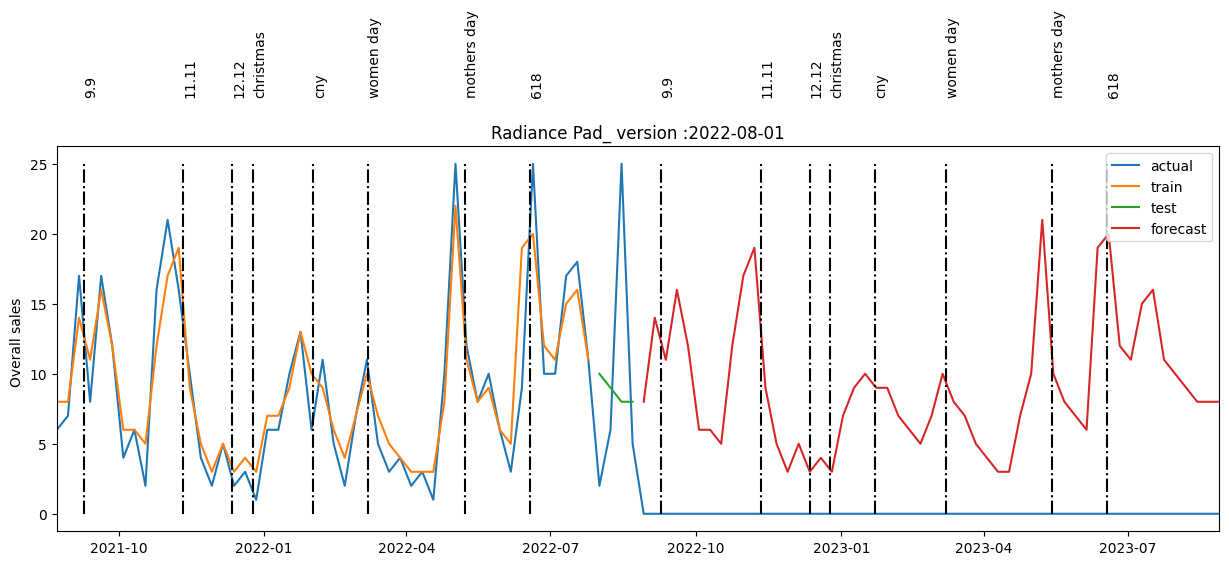

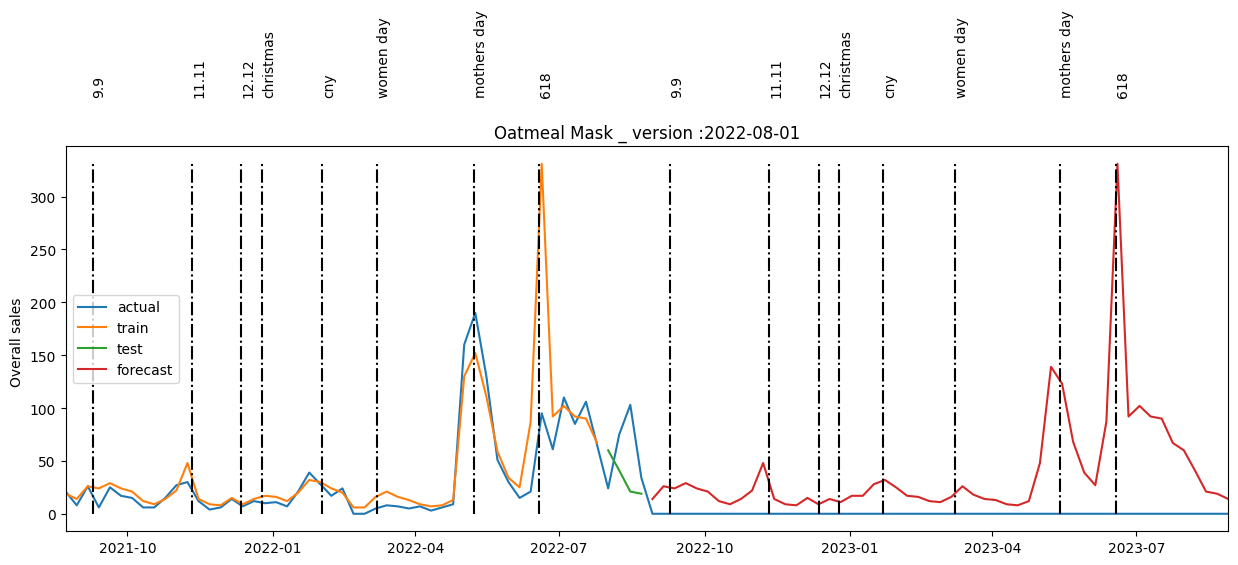

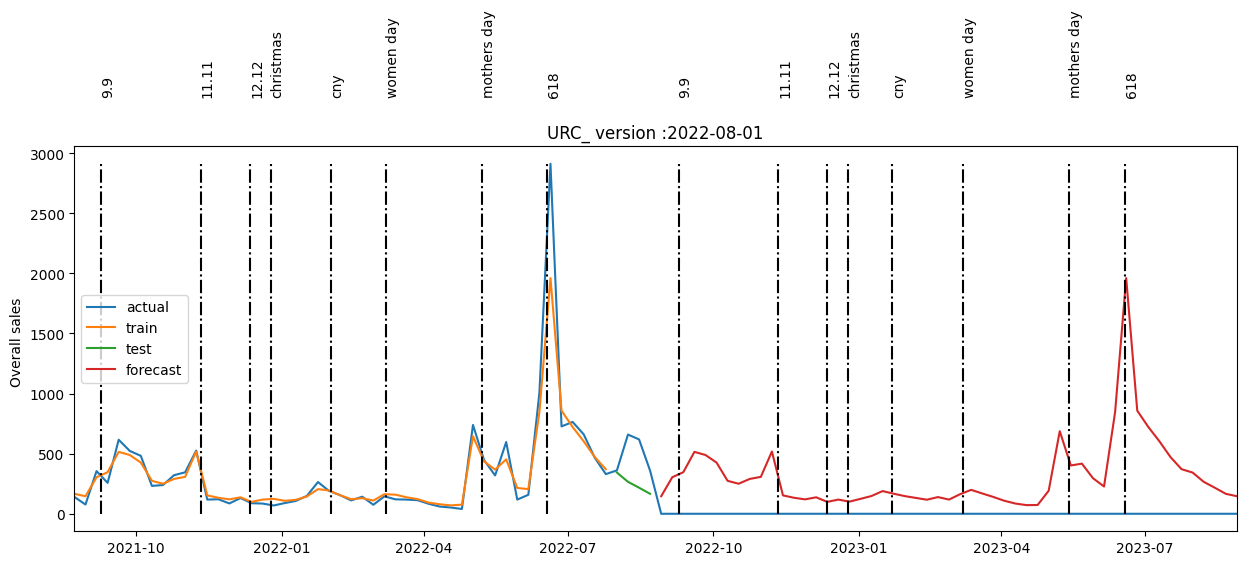

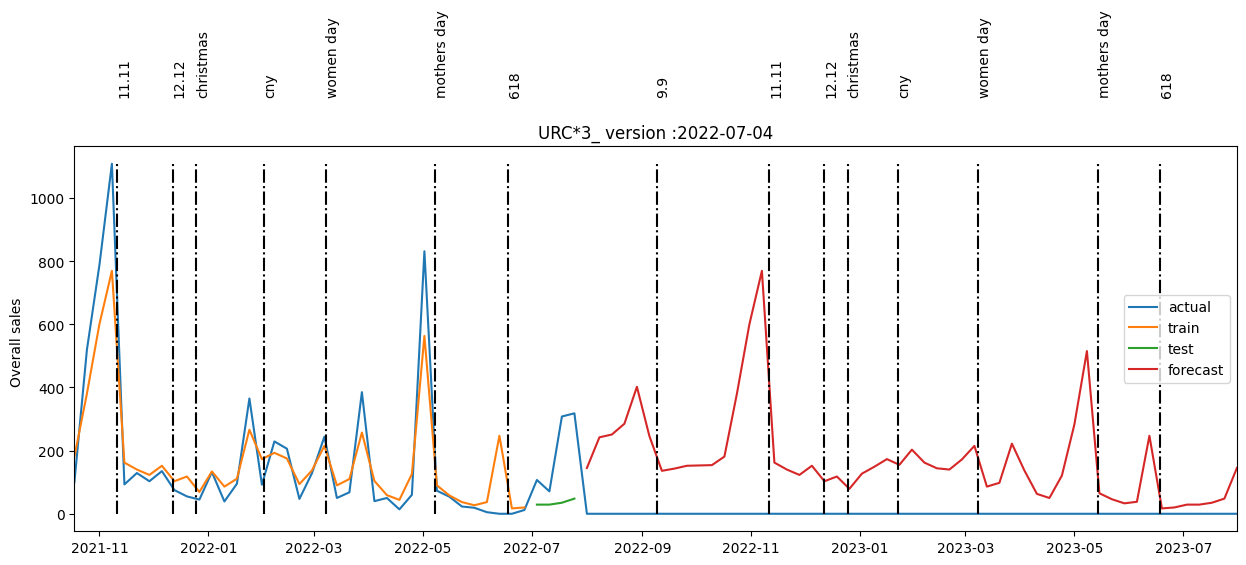

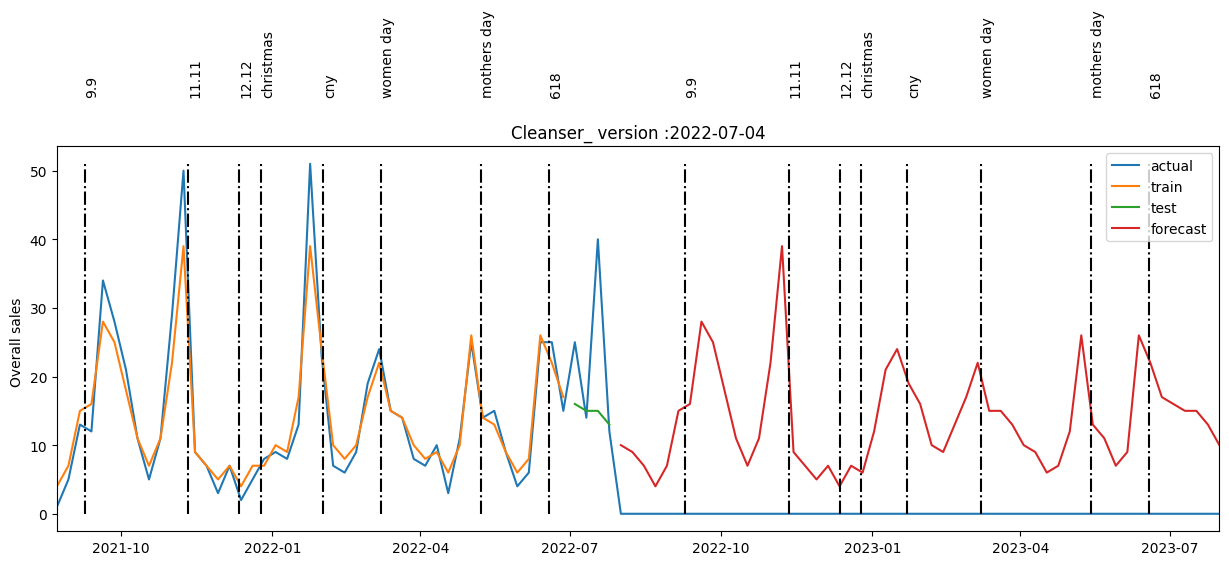

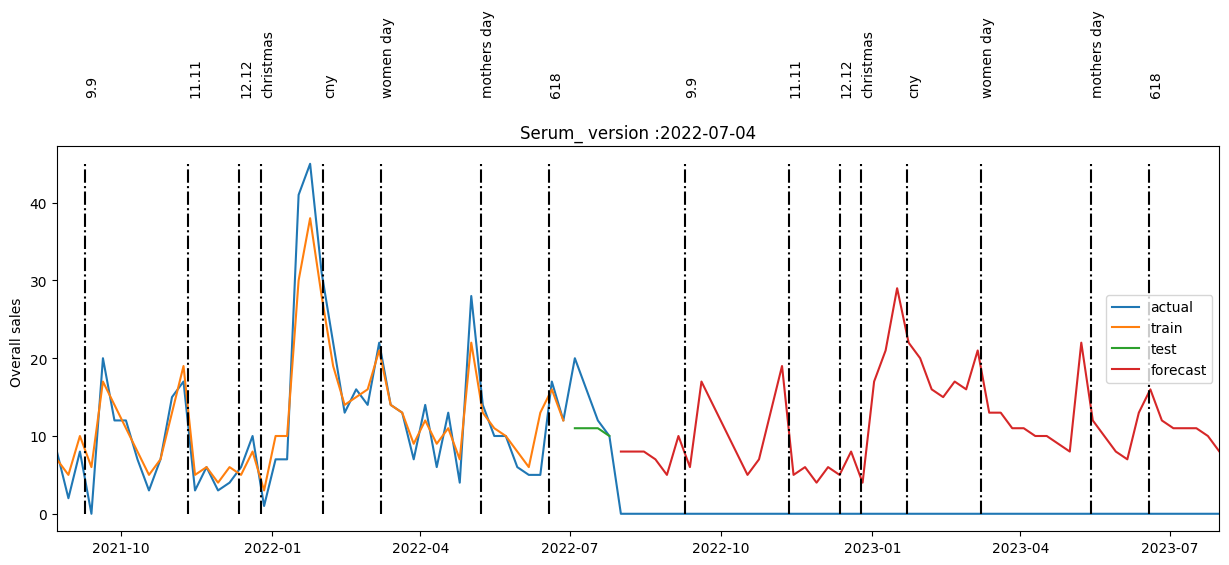

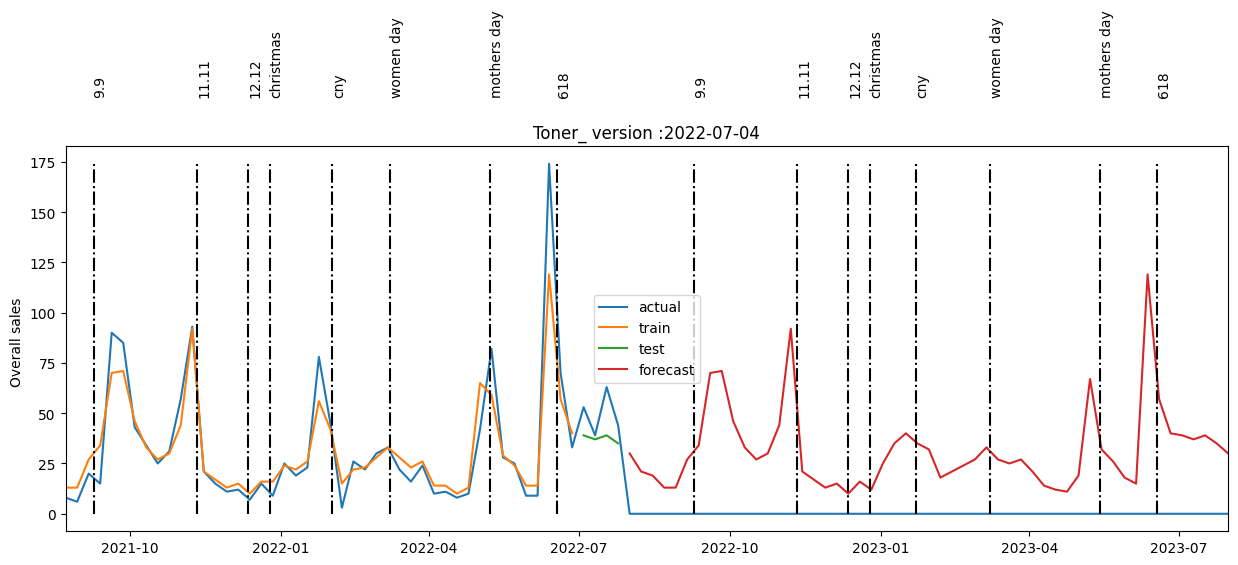

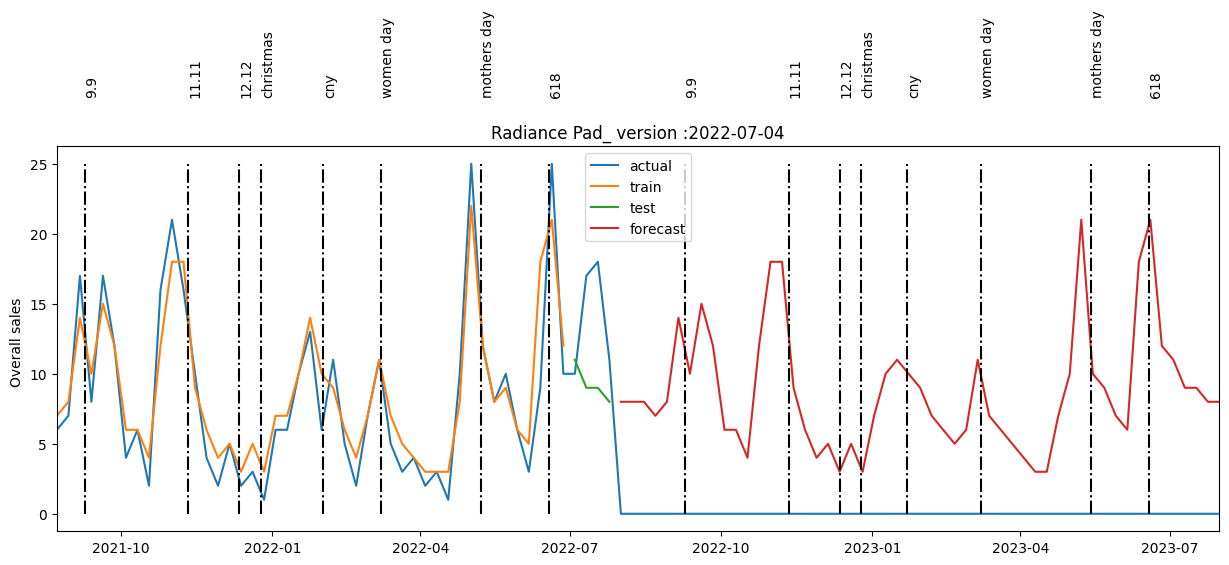

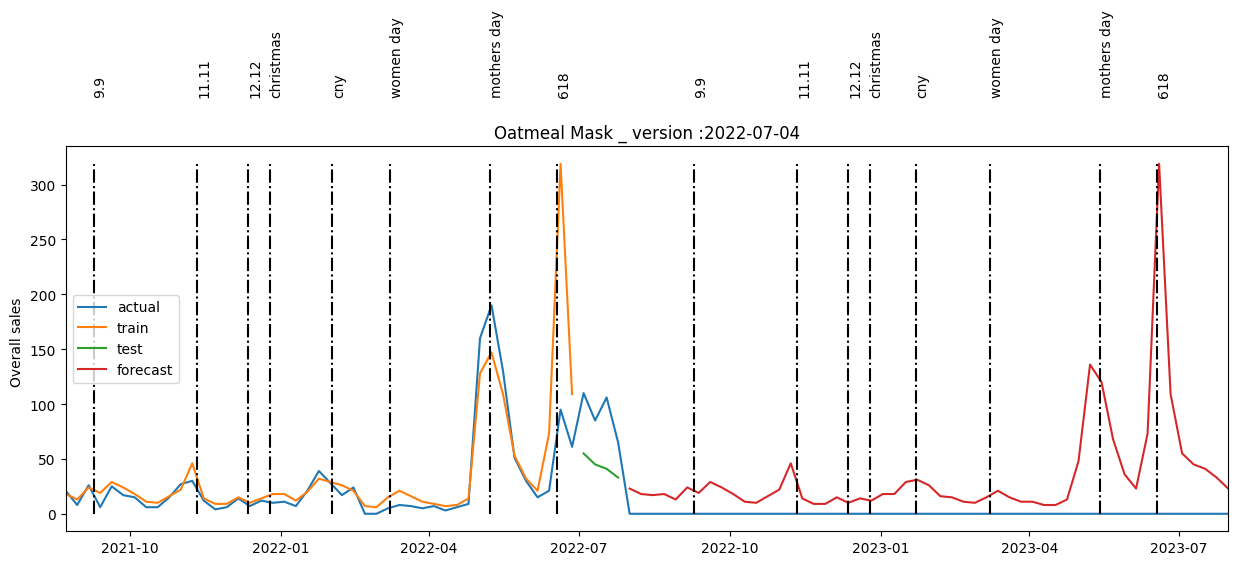

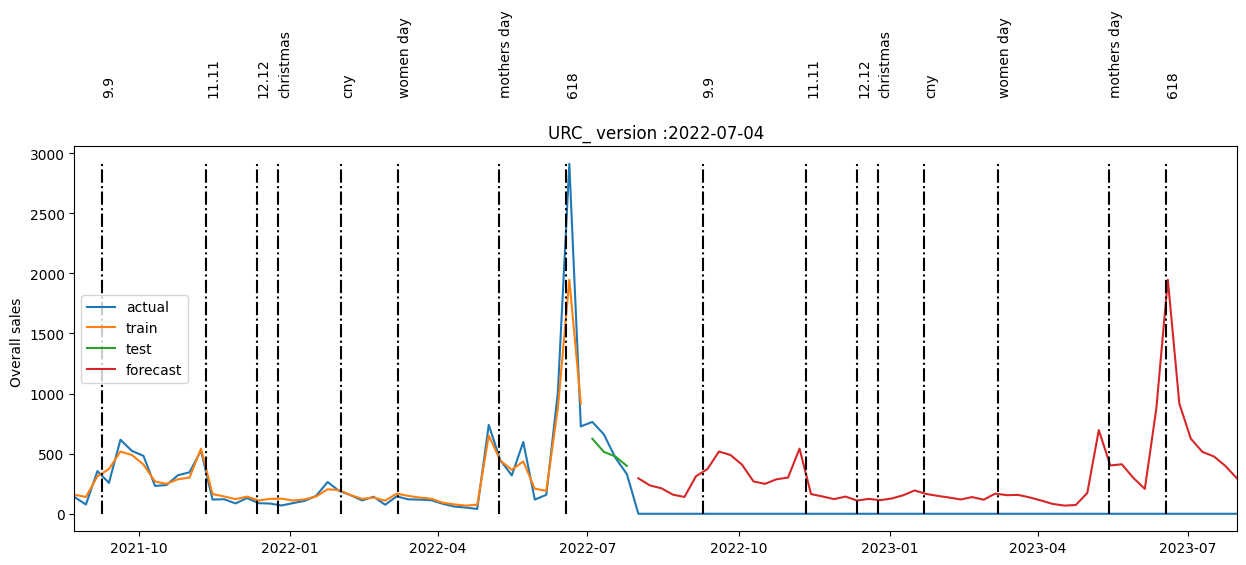

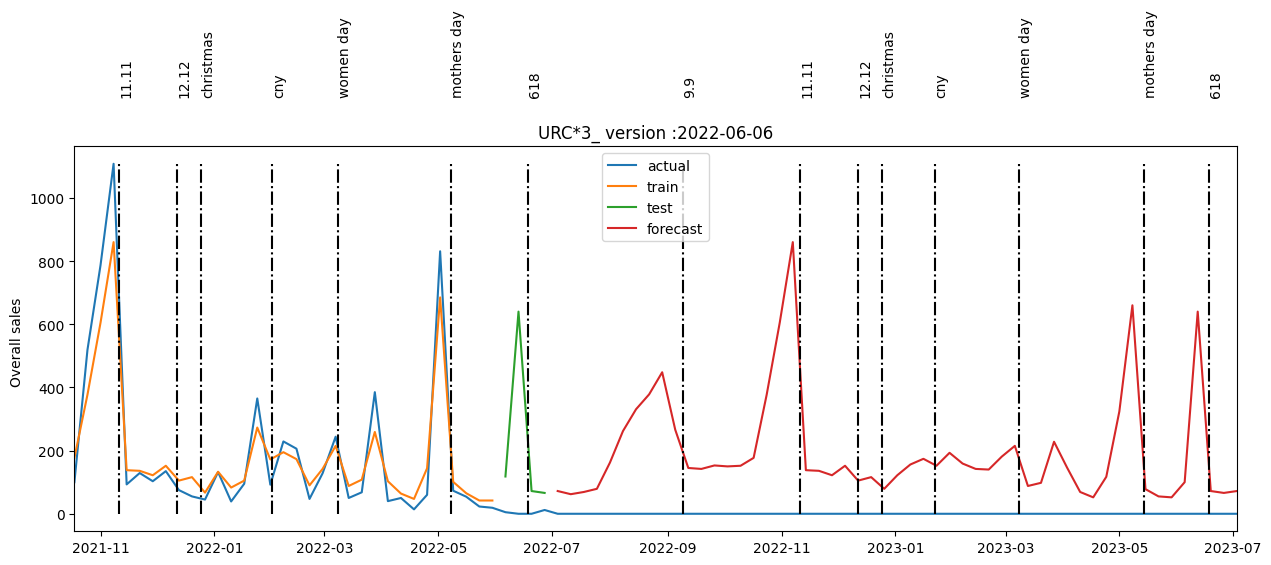

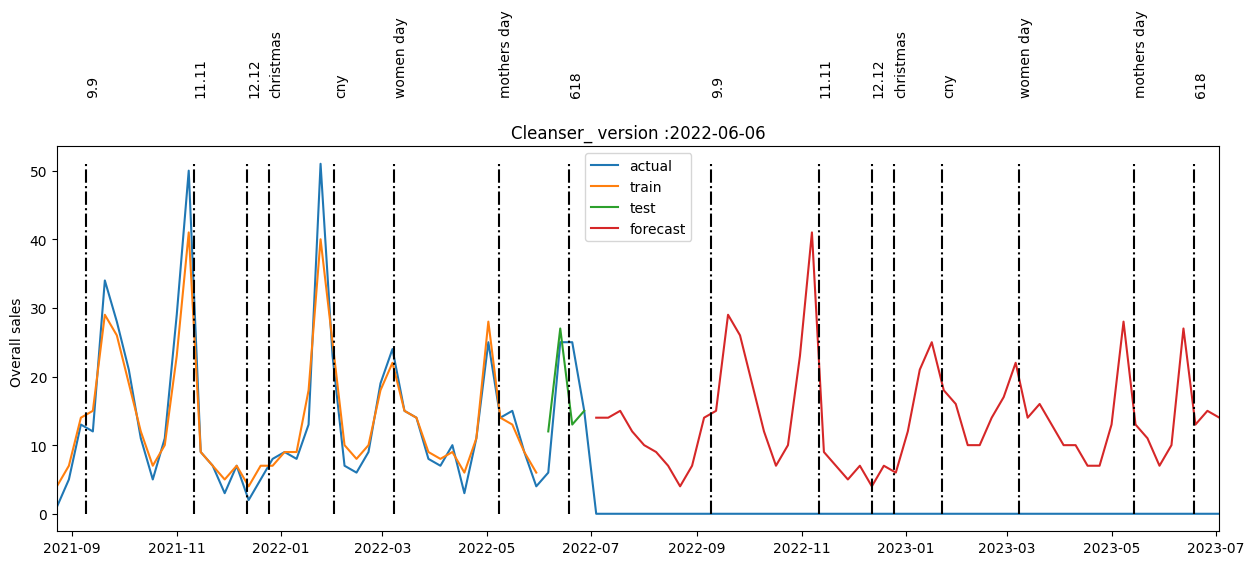

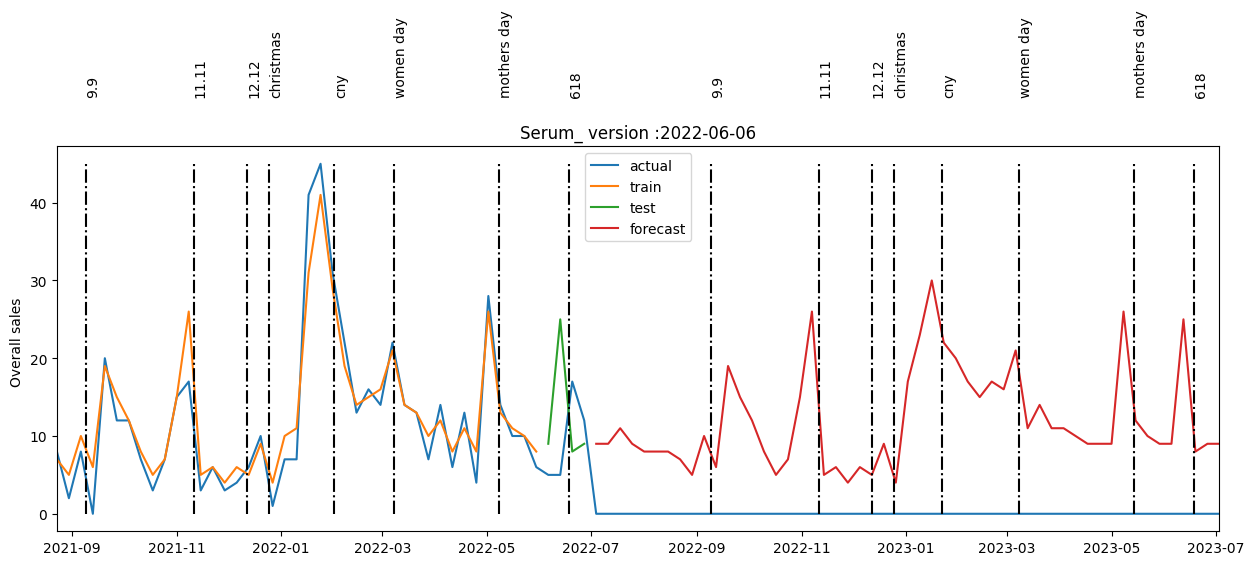

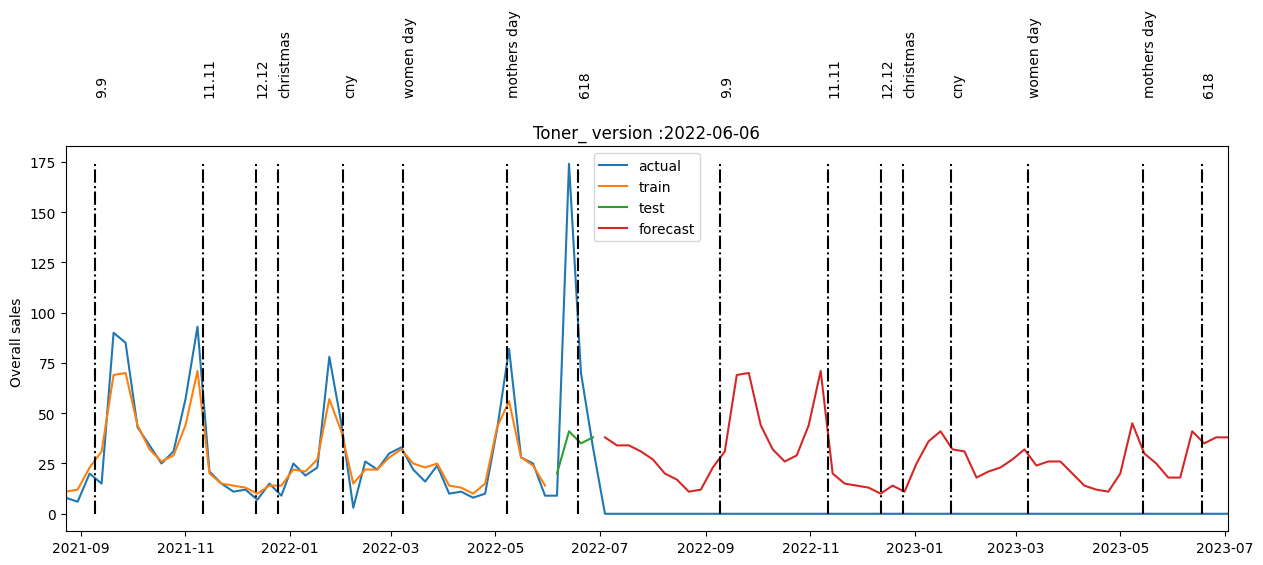

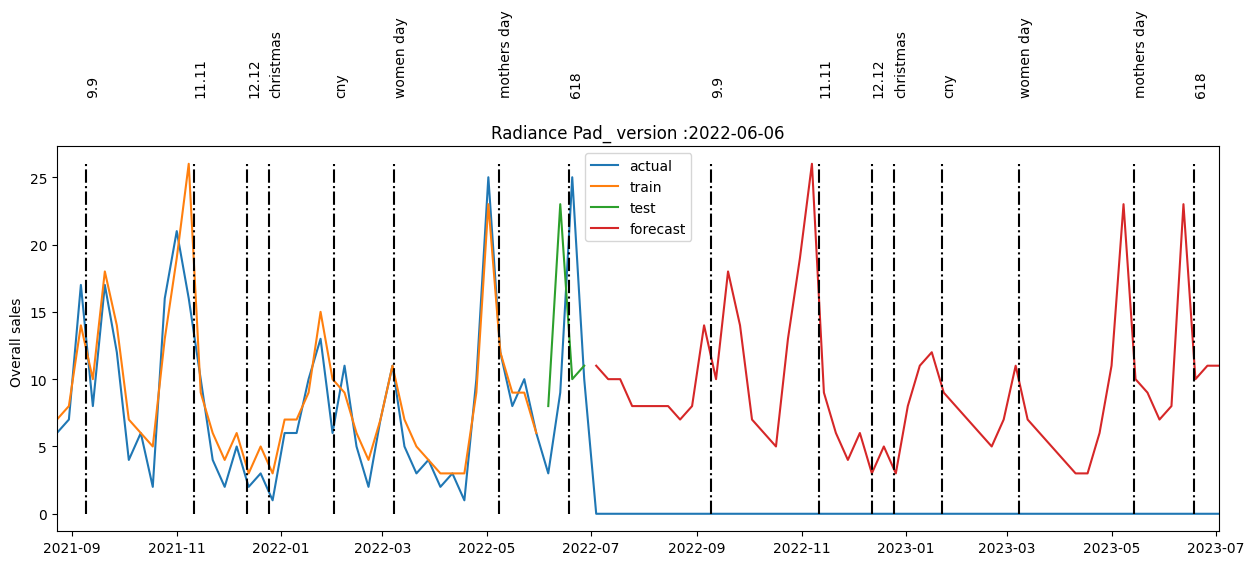

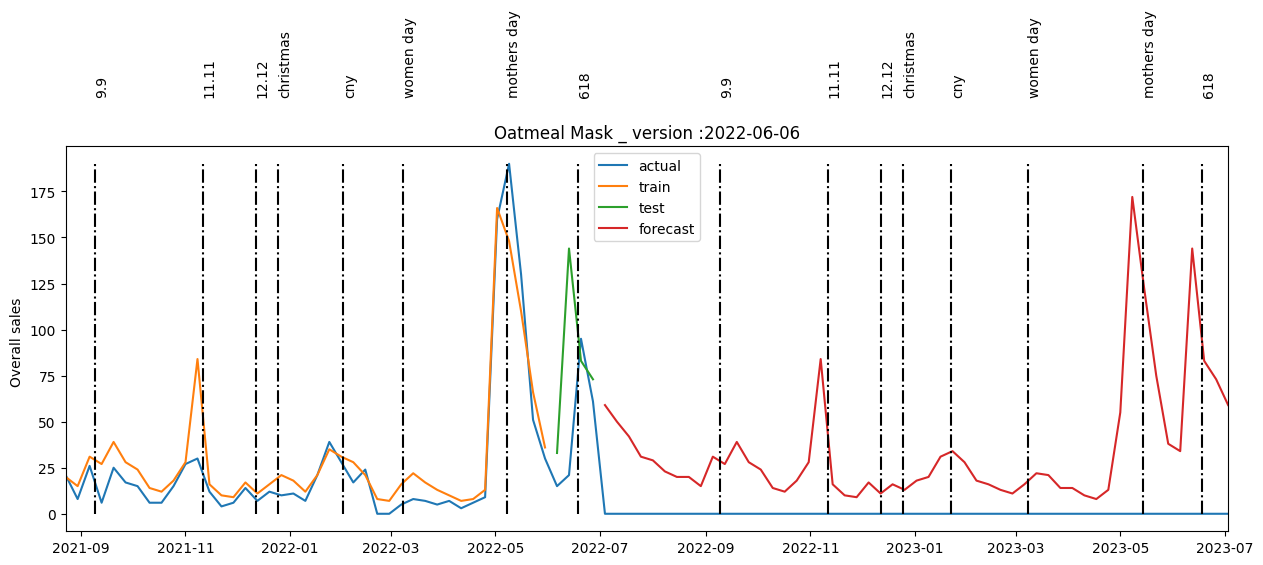

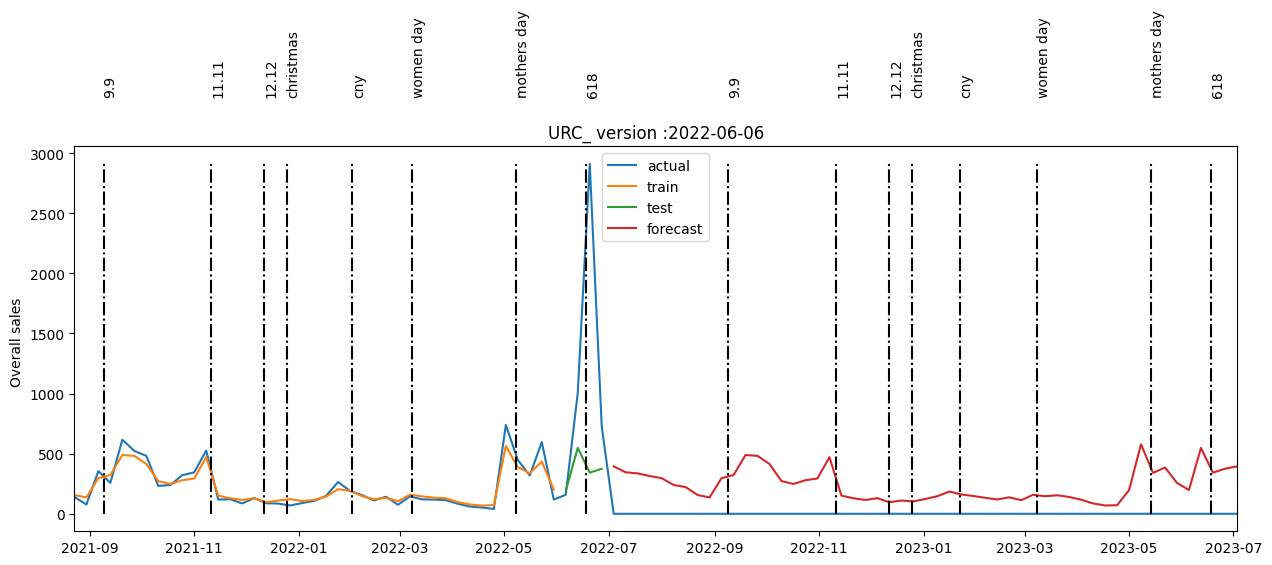

In [43]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    sku_custs =  this_predict.sku.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku'] == this_sku_cust]
        sku_desc = this_ts.shortname.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title( str(sku_desc) + "_ version :" + str(versions[i]))
        plt.legend()
        plt.show()

In [44]:
for this_version in range(len(versions)):
    for c in rf_yhat.id.unique():
        ts = rf_yhat.loc[ (rf_yhat.id == c) & (rf_yhat.version == versions[this_version])].groupby("ts").sum()
        plt.figure(figsize=(15,5))
        plt.plot(ts.y, label="Actuals")
        plt.plot(ts.yhat, label="Forecast main")
        plt.plot(ts.y_hw, label="Forecast Holts")
        plt.legend(loc = "upper right")
        plt.title(" ID: {} Version : {}".format(c,versions[this_version] ))
        plt.show()

NameError: name 'rf_yhat' is not defined

### Results

In [ ]:
all_forecast_versions = predict_df.version.unique()
forecast_version_to_test_dates = {}
count = 0
for i in all_forecast_versions:
    this_test_dates = pd.date_range(
        start= pd.to_datetime(all_dates[i]['test'][0]),
        end= pd.to_datetime(all_dates[i]['forecast'][7]),
        freq=freq,
    )
    forecast_version_to_test_dates.update({i: this_test_dates})
    count += 4
forecast_version_to_test_dates

In [ ]:
results_sp3 = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        ts.drop(columns={'y'}, inplace = True)
        ts = pd.merge(ts, df[['ts', 'id', 'y']], on = ['ts', 'id'], how = 'left')
        ts = ts[ts['ts'] <= np.max(df['ts'])]
        test = ts.loc[ ts.ts.isin( forecast_version_to_test_dates[versions[i]]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "customer" : 'All',
            "sku": ts["sku"][0],
            "test_start": forecast_version_to_test_dates[versions[i]][0],
            "test_end":  np.max(ts['ts']),
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results_sp3 = results_sp3.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "customer", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results_sp3 = results_sp3[main_cols + list(results_sp3.drop(columns=main_cols).columns)].copy()
results_sp3["sp3"] = results_sp3["total_actual"] / results_sp3["total_forecast"]
results_sp3["sp3"] = np.nan_to_num(results_sp3["sp3"], nan=1, posinf=0, neginf=0)
results_sp3["model"] = predict_df.model[0]

results_sp3.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results_sp3.groupby("customer").mean()
results_sp3.groupby("customer").median()

for i in range(len(versions)): 
    this_results = results_sp3[results_sp3['version'] == versions[i]]
    plt.figure(figsize=(8,2))
    #plt.ylim(0,15)
    sns.boxplot(data=this_results, y="sp3", x="customer")
    plt.show()

    

In [ ]:
results_sp1_att = results.copy()
results_sp1_att.drop(columns={'id'},inplace=True)
print(results_sp1_att.shape)
att_df1 = at[['cases', 'description', 'level2', 'prod_code', 'prod_hierarchy', 'size','sku', 'sku_desc', 'sku_type', 'units']].drop_duplicates()
print(results_sp1_att.shape)
results_sp1_att = pd.merge(results_sp1_att,att_df1,on=['sku'])
print(results_sp1_att.shape)
results_sp1_att = pd.merge(results_sp1_att,att_main,on='sku')
results_sp1_att['date_num'] = pd.to_numeric(results_sp1_att['test_start'])
results_sp1_att['sp1'] = results_sp1_att['sp1'].round(2)
results_sp1_att.head()

In [49]:
results_sp3_att = results_sp3.copy()
results_sp3_att.drop(columns={'id'},inplace=True)
print(results_sp3_att.shape)
att_df1 = at[['cases', 'description', 'level2', 'prod_code', 'prod_hierarchy', 'size','sku', 'sku_desc', 'sku_type', 'units']].drop_duplicates()
print(results_sp3_att.shape)
results_sp3_att = pd.merge(results_sp3_att,att_df1,on=['sku'])
print(results_sp3_att.shape)
results_sp3_att = pd.merge(results_sp3_att,att_main,on='sku')
results_sp3_att['date_num'] = pd.to_numeric(results_sp3_att['test_start'])

results_sp3_att['sp3'] = results_sp3_att['sp3'].round(2)
results_sp3_att.head()

(21, 14)
(21, 14)
(21, 23)


sku customer     version test_start   test_end  total_actual  \
0  80692947      All  2022-08-01 2022-08-01 2022-08-29        1346.0   
1  80692947      All  2022-07-04 2022-07-04 2022-08-29        2150.0   
2  80692947      All  2022-06-06 2022-06-06 2022-08-29        2162.0   
3  80702886      All  2022-08-01 2022-08-01 2022-08-29          64.0   
4  80702886      All  2022-07-04 2022-07-04 2022-08-29         155.0   

   total_forecast        rmse         mae     smape           mape     maape  \
0          2001.0  427.471403  399.000000  1.311484   2.040337e+01  1.184148   
1          1466.0  341.032419  253.555556  1.189256   9.729563e+00  0.845123   
2          2311.0  317.217460  222.750000  1.174560            inf  0.957165   
3            44.0   11.730303    7.600000  0.761599  3.595386e+307  0.555045   
4            96.0   12.749728    8.555556  0.636345  1.997437e+307  0.450238   

    sp3               model  cases                           description  \
0  0.67  Model per customer     78   FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW   
1  1.47  Model per customer     78   FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW   
2  0.94  Model per customer     78   FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW   
3  1.45  Model per customer     57  FAB CLEANSER EUP 142G(50Z)X57 NONSTK   
4  1.61  Model per customer     57  FAB CLEANSER EUP 142G(50Z)X57 NONSTK   

         level2  prod_code prod_hierarchy  size  \
0  Ultra Repair   10024911            FAB   2.0   
1  Ultra Repair   10024911            FAB   2.0   
2  Ultra Repair   10024911            FAB   2.0   
3           NaN   10024916            FAB   5.0   
4           NaN   10024916            FAB   5.0   

                                            sku_desc  sku_type units  \
0  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...     Cream    Oz   
1  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...     Cream    Oz   
2  FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...     Cream    Oz   
3  FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...  Cleanser    Oz   
4  FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...  Cleanser    Oz   

  shortname             date_num  
0     URC*3  1659312000000000000  
1     URC*3  1656892800000000000  
2     URC*3  1654473600000000000  
3  Cleanser  1659312000000000000  
4  Cleanser  1656892800000000000

In [50]:
import write_data_table
write_data_table.send_data(results_sp1_att,'sp1_taiwan','w6')
write_data_table.send_data(results_sp3_att,'sp3_taiwan','w6')
write_data_table.send_data(predict_df_op,'prediction_taiwan','w6')
write_data_table.send_data(predict_df_monthly_op,'predict_monthly_taiwan','w6')
write_data_table.send_data(predict_df_monthly_op_long,'predict_monthly_taiwan_long','w6')

Index(['sku', 'version', 'test_start', 'test_end', 'total_actual',
       'total_forecast', 'rmse', 'mae', 'smape', 'mape', 'maape', 'sp1',
       'model', 'customer', 'cases', 'description', 'level2', 'prod_code',
       'prod_hierarchy', 'size', 'sku_desc', 'sku_type', 'units', 'shortname',
       'date_num'],
      dtype='object')
Index(['sku', 'customer', 'version', 'test_start', 'test_end', 'total_actual',
       'total_forecast', 'rmse', 'mae', 'smape', 'mape', 'maape', 'sp3',
       'model', 'cases', 'description', 'level2', 'prod_code',
       'prod_hierarchy', 'size', 'sku_desc', 'sku_type', 'units', 'shortname',
       'date_num'],
      dtype='object')
Index(['version', 'ts', 'id', 'sku', 'actuals', 'forecast', 'cases',
       'description', 'level2', 'prod_code', 'prod_hierarchy', 'size',
       'sku_desc', 'sku_type', 'units', 'shortname', 'date_num'],
      dtype='object')
Index(['version', 'ts', 'id', 'sku', 'actuals', 'forecast', 'cases',
       'description', 'level2',

In [51]:
predict_df_monthly_op.version.unique()

array(['2022-08-01', '2022-07-04', '2022-06-06'], dtype=object)

In [88]:
write_data_table.send_data(predict_df_monthly_op,'predict_monthly_taiwan','w6')

Index(['version', 'ts', 'id', 'sku', 'actuals', 'forecast', 'cases',
       'description', 'level2', 'prod_code', 'prod_hierarchy', 'size',
       'sku_desc', 'sku_type', 'units', 'shortname', 'date_num'],
      dtype='object')
